# 5FR Win Probability
### Author: Akshay Easwaran [akeaswaran@me.com](mailto:akeaswaran@me.com)

#### Prereqs/Installation
Read the README file for this repo to get the proper files downloaded and sorted locally.

#### What's Included
* Postgame win probability model -- linear regression based, predicting margin of victory based on the [Five Factors of Football](https://www.footballstudyhall.com/2014/1/24/5337968/college-football-five-factors). MoV has a normal distribution, so we can use the z-score of the predicted value to produce a win probability based on the team performance ratings generated from the statistics from the game.
* Second-order wins: sum of a team's win probabilities; how many games a team should have won given their performances
* Game Predictions (and validations): based on an adjustable number of a team's previous team performance ratings in a given year. Adjusted for P5 vs G5, overall strength of schedule, and conference strength of schedule. Note: the projected MOV produced is **NOT** adjusted by 2.5 for home-field advantage.
* Schedule analysis: charts describing a given team's performance against projections and listing projections against a given set of teams
* Team comparison charts: graphs comparing teams' 5FR rating over time
* Historic rankings: a ranking of teams based on their mean 5FR. Not adjusted for strength of schedule or conference strength.

#### Disclaimer: 
I am not responsible for any bets made using this utility.
#### License: 
MIT - See LICENSE.md for details.

In [15]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt

In [16]:
p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [17]:
def retrieveCfbData(endpoint, team, year, week, season_type):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType={season_type}&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [18]:
# init data retrieval
teams = pd.read_csv("data/teams/2019.csv", encoding = 'latin-1')
ep_data = pd.read_csv("results/ep.csv", encoding = 'latin-1')
punt_sr_data = pd.read_csv("results/punt_sr.csv", encoding = 'latin-1')
fg_sr_data = pd.read_csv("results/fg_sr.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2012, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys, sort=False)

print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

Total Games: 6644
Total Drives: 171692
Total Plays: 1210147


In [19]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
# pbp_data = pbp_data[
#     (pbp_data.down != 0)
# ]

Clean Drives: 170795


In [20]:
pbp_data.distance = pbp_data.distance.astype(float)

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Defensive 2pt Conversion","2pt Conversion","Blocked Field Goal Touchdown","Punt Return Touchdown"]
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Timeout","End of Half","End of Game","Uncategorized","Penalty","Safety","placeholder","End of Period", "End Period"]
off_play_types = pbp_data[(~(pbp_data.play_type.isin(ignore_types))) & (~(pbp_data.play_type.isin(st_types)))].play_type.drop_duplicates().tolist()
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]
bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types)))
     & (~pbp_data.play_type.str.contains('Sack')) ,['yards_gained']] = 0

In [21]:
off_play_types

['Pass Incompletion',
 'Pass Completion',
 'Rush',
 'Sack',
 'Pass Interception',
 'Pass',
 'Pass Reception',
 'Fumble Recovery (Opponent)',
 'Fumble Recovery (Own)',
 'Passing Touchdown',
 'Rushing Touchdown',
 'Pass Interception Return',
 'Fumble Return Touchdown',
 'Interception Return Touchdown',
 'Interception',
 'Two Point Rush']

In [22]:
# %%timeit
def assign_eqppp_vector(play_type, yard_line, yards_gained):
    return 0 if (play_type in st_types) else (ep_data.iloc[max(min(100, (yard_line + yards_gained)), 0)].ep - ep_data.iloc[max(min(yard_line, 100), 0)].ep)

def assign_eqppp(x):
    return ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(x.yard_line, 100), 0)].ep

if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = pbp_data.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)

In [23]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,clock.seconds,yard_line,down,distance,yards_gained,play_type,play_text,ppa,year,EqPPP
0,0,322430009013,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,7,0,...,26,35,-1,-1.0,15,Kickoff,Alex Garoutte kickoff for 65 yards returned by...,NaN,2012,0.000000
1,1,322430009007,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,27,72,1,10.0,0,Pass Incompletion,Taylor Kelly pass incomplete to Chris Coyle.,-0.512082,2012,0.000000
2,2,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,18,72,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253
3,3,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,45,75,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460
4,4,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,26,91,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449


In [24]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if ((play_type in bad_types) | (play_type in st_types)):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if ((play.play_type in bad_types) | (play.play_type in st_types)):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained, play_type):
    if ((play_type in bad_types) | (play_type in st_types)):
        return False
    elif (yards_gained >= 15):
        return True
    else:
        return False
    
if 'play_explosive' not in pbp_data.columns:
    pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained, pbp_data.play_type)
if 'play_successful' not in pbp_data.columns:
    pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))

standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

def is_punt_successful(x):
    return x.Net >= punt_sr_data[punt_sr_data.Yardline == x.Yardline].ExpPuntNet.to_list()[0]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [25]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,down,distance,yards_gained,play_type,play_text,ppa,year,EqPPP,play_explosive,play_successful
0,0,322430009013,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,7,0,...,-1,-1.0,15,Kickoff,Alex Garoutte kickoff for 65 yards returned by...,NaN,2012,0.000000,False,False
1,1,322430009007,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,1,10.0,0,Pass Incompletion,Taylor Kelly pass incomplete to Chris Coyle.,-0.512082,2012,0.000000,False,False
2,2,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253,False,False
3,3,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460,True,True
4,4,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449,False,True


In [26]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'ActualTO', 'AvgEqPPP', 'TotalEqPPP','IsoPPP','HavocRate','SackRate','KickoffSR','KickoffReturnSR','PuntSR','PuntReturnSR','FGEff']

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def calculate_isoppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set[opp_set.play_successful == True].EqPPP)
        total += len(opp_set[opp_set.play_successful == True])
    iso_ppp = 0 if total == 0 else (eq_ppp / total)
    return iso_ppp

def calculate_avgeqppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set.EqPPP)
        total += len(opp_set)
    eq_ppp = 0 if total == 0 else (eq_ppp / total)
    return eq_ppp

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.offense == team)]
    off_sr = calculate_success_rate(team_off_plays, st_types)
    off_er = calculate_exp_rate(team_off_plays, st_types)
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    opp_isoppp = calculate_isoppp_in_scoring_opps(pbp, scoring_opps, team)
    opp_avgeqppp = calculate_avgeqppp_in_scoring_opps(pbp, scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd],
        'OppIsoPPP' : [opp_isoppp],
        'OppAvgEqPPP' : [opp_isoppp]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def calculate_sack_rate(pbp, team):
    team_sack = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((pbp.play_type == 'Sack'))]
    return verify_division(len(team_sack), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    actual_to = len(team_ints_off) + len(fum_plays[(fum_plays.offense == team) & (fum_plays.play_type.str.contains('Fumble Recovery (Opponent)', regex=False))])
    havoc = calculate_havoc_rate(pbp, team)
    sack = calculate_sack_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'ActualTO' : [actual_to],
        'HavocRate': [havoc],
        'SackRate': [sack]
    })

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt","Field Goal Good","Field Goal Missed"]
def generate_team_st_stats(pbp, team):
    st_plays = pbp[(pbp.play_type.isin(st_types))]
    
    fg_plays = st_plays[st_plays.play_type.str.contains("Field Goal") & (st_plays.offense == team)]
    fg_made = fg_plays[fg_plays.play_type.str.contains("Good")]
    fg_eff = verify_division(len(fg_made), len(fg_plays))
    
    xp_plays = st_plays[st_plays.play_type.str.contains("Extra Point") & (st_plays.offense == team)]
    xp_made = xp_plays[xp_plays.play_type.str.contains("Good")]
    xp_eff = verify_division(len(xp_made), len(xp_plays))
    
    kickoff_plays = st_plays[st_plays.play_type.str.contains("Kickoff") & ~(st_plays.play_text.str.contains("on-side"))]
    tmp = pd.DataFrame(data=kickoff_plays.play_text.str.extract('kickoff for (\d+) ya*r*ds', expand=True).astype(float))
    kickoff_distance = pd.DataFrame(columns=["Index","Yardline","Offense","Defense","PlayText","Distance","Return","Net"])
    if (len(tmp) > 0):
        kickoff_distance["Index"] = tmp.index
        kickoff_distance["Offense"] = kickoff_distance.apply(lambda x: kickoff_plays.offense[x.Index],axis=1)
        kickoff_distance["Defense"] = kickoff_distance.apply(lambda x: kickoff_plays.defense[x.Index],axis=1)
        kickoff_distance["Yardline"] = kickoff_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (kickoff_plays.yard_line[x.Index] % 50)),axis=1)
        kickoff_distance["PlayText"] = kickoff_distance.apply(lambda x: kickoff_plays.play_text[x.Index],axis=1)
        kickoff_distance["Distance"] = tmp.values
        kickoff_distance["Return"] = kickoff_distance.apply(lambda x: kickoff_plays.yards_gained[x.Index],axis=1)
        kickoff_distance["Net"] = kickoff_distance.Distance - kickoff_distance.Return
    kickoff_sr = verify_division(len(kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Offense == team)]), len(kickoff_distance[(kickoff_distance.Offense == team)]))
    kick_return_sr = verify_division(len(kickoff_distance[(kickoff_distance.Return >= 24) & (kickoff_distance.Defense == team)]), len(kickoff_distance[(kickoff_distance.Defense == team)]))
    
    punt_plays = st_plays[st_plays.play_type.str.contains("Punt")]
    pt_tmp = pd.DataFrame(data=punt_plays.play_text.str.extract('punt for (\d+) ya*r*ds', expand=True).astype(float))
    punt_distance = pd.DataFrame(columns=["Index","Offense","Defense","Yardline","Distance","Return","Net","Successful"])
    if (len(pt_tmp) > 0):
        punt_distance["Index"] = pt_tmp.index
        punt_distance["Offense"] = punt_distance.apply(lambda x: punt_plays.offense[x.Index],axis=1)
        punt_distance["Defense"] = punt_distance.apply(lambda x: punt_plays.defense[x.Index],axis=1)
        punt_distance["Yardline"] = punt_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (punt_plays.yard_line[x.Index] % 50)),axis=1)
        punt_distance["Distance"] = pt_tmp.values
        punt_distance["Return"] = punt_distance.apply(lambda x: punt_plays.yards_gained[x.Index],axis=1)
        punt_distance["Net"] = punt_distance.Distance - punt_distance.Return
        punt_distance['Successful'] = punt_distance.apply(lambda x: is_punt_successful(x), axis=1)
        
    punt_sr = verify_division(len(punt_distance[(punt_distance.Successful == True) & (punt_distance.Offense == team)]), len(punt_distance[(punt_distance.Offense == team)]))
    punt_return_sr = verify_division(len(punt_distance[(punt_distance.Successful == False) & (punt_distance.Defense == team)]), len(punt_distance[(punt_distance.Defense == team)]))
    
    return pd.DataFrame({
        'team' : [team],
        'FGEff': [fg_eff],
        'XPEff' : [xp_eff],
        'KickoffSR' : [kickoff_sr],
        'KickoffReturnSR' : [kick_return_sr],
        'PuntSR' : [punt_sr],
        'PuntReturnSR' : [punt_return_sr]
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
    return translate(team_stat_pack.AvgEqPPPDiff, pbp_data.EqPPP.min()-pbp_data.EqPPP.max(), pbp_data.EqPPP.max()-pbp_data.EqPPP.min(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 10)

def create_fp_index(team_stat_pack):
    return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,3.5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 4) + translate(team_stat_pack.OppSRDiff, -1,1,0,2.5)

def create_turnover_index(team_stat_pack):
    return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 3) + translate(team_stat_pack.SackRateDiff, -1, 1, 0, 3) + translate(team_stat_pack.HavocRateDiff, -1, 1, 0, 4)
    #return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 10)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.10 * create_turnover_index(team_stat_pack)

def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    season_type = stringify_entry(game_data.season_type)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week, season_type))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week, season_type))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = np.vectorize(is_explosive)(game_pbp.yards_gained, game_pbp.play_type)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = np.vectorize(is_successful)(game_pbp.down, game_pbp.distance, game_pbp.yards_gained, game_pbp.play_type)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = game_pbp.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)
        
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    home_team_st_stats = generate_team_st_stats(game_pbp, home_team)
    away_team_st_stats = generate_team_st_stats(game_pbp, away_team)
    
    home_team_stats = pd.merge(home_team_stats, home_team_st_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_st_stats, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
box_score = calculate_box_score(401013183, 2018)
box_score

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.124959,-0.040309,-0.002715,0.0,0.166667,0.119048,0.119048,0.333333,5.070568,0.141137
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.124959,0.040309,0.002715,0.0,-0.166667,-0.119048,-0.119048,-0.333333,4.929432,-0.141137


In [27]:
def break_down_box_score(box):
    box_comps = pd.DataFrame(data={'Team':box.Team})
    box_comps['Eff'] = box.apply(lambda x: create_eff_index(x), axis=1)
    box_comps['Expl'] = box.apply(lambda x: create_expl_index(x), axis=1)
    box_comps['FinDrv'] = box.apply(lambda x: create_finish_drive_index(x), axis=1)
    box_comps['FldPos'] = box.apply(lambda x: create_fp_index(x), axis=1)
    box_comps['Trnovr'] = box.apply(lambda x: create_turnover_index(x), axis=1)
    box_comps['5FR'] = box['5FR']
    box_comps['5FRDiff'] = box['5FRDiff']
    return box_comps
break_down_box_score(box_score)

,Team,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff
0,Virginia,5.142022,5.050452,5.386628,4.46,5.017309,5.070568,0.141137
1,Virginia Tech,4.857978,4.949548,4.613372,5.54,4.982691,4.929432,-0.141137


In [28]:
# %%timeit
import os.path
from os import path

game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
if (('stored_game_boxes' not in locals()) & (~path.exists("results/box-scores.csv"))):
    print(f"[Local] Box Scores are not available, generating them from scratch...")
    stored_game_boxes = pd.DataFrame()
    for i, row in games.iterrows():
        gameId = row.id
        print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}...")
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}...")
        if ((row.home_team in team_list) & (row.away_team in team_list)):
            box_score = calculate_box_score(gameId, row.season)
            if (box_score is not None):
                print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}.")
                stored_game_boxes = stored_game_boxes.append(box_score)
                print(f"[{i+1}/{len(game_ids)}] Aggreggated game_id {gameId} to master data copy.")
            else:
                print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing.")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS.")
    print(f"[Local] Finished generating {len(stored_game_boxes)} box scores and 5FR margins from scratch.")
else:
    proceed = True
    if ('stored_game_boxes' in locals()):
        print(f"Relying on 'stored_game_boxes' currently loaded into memory")
    elif (path.exists("results/box-scores.csv")):
        print(f"Loading box scores from file...")
        stored_game_boxes = pd.read_csv("results/box-scores.csv", encoding="latin-1")
    else:
        print(f"[Local] No box scores available, bailing out...")
        proceed = False
        
    if (proceed == True):
        print(f"[Local] Box Scores are available in local, updating five factors ratings now...")
        stored_game_boxes['5FR'] = stored_game_boxes.apply(lambda row: calculate_five_factors_rating(row), axis=1)
        print(f"[Local] Grouping box score rows by GameID...")
        groups = stored_game_boxes.groupby('GameID')
        print(f"[Local] Generated {len(groups)} box score groups by GameID.")
        current = 0
        for (name, group) in groups:
            print(f"[{current+1}/{len(groups)}] Updating 5FR Margin for game_id {name}...")
            group_ratings = group['5FR']
            top_diff = group_ratings.iloc[0] - group_ratings.iloc[1]
            bot_diff = group_ratings.iloc[1] - group_ratings.iloc[0]
            group['5FRDiff'] = [top_diff, bot_diff]
            print(f"[{current+1}/{len(groups)}] Updated 5FR Margin for game_id {name}.")
            current+=1
        print(f"[Local] Finished updating box scores with new 5FR margins.")

if ('stored_game_boxes' in locals()):
    print(f"[Local] Writing updated box scores to file...")
    stored_game_boxes.dropna(inplace=True)
    stored_game_boxes.to_csv("results/box-scores.csv", index=False, sep=",")
    print(f"[Local] Wrote updated box scores to file.")
    stored_game_boxes.head()

Loading box scores from file...
[Local] Box Scores are available in local, updating five factors ratings now...
[Local] Grouping box score rows by GameID...
[Local] Generated 5670 box score groups by GameID.
[1/5670] Updating 5FR Margin for game_id 322430041...
[1/5670] Updated 5FR Margin for game_id 322430041.
[2/5670] Updating 5FR Margin for game_id 322430238...
[2/5670] Updated 5FR Margin for game_id 322430238.
[3/5670] Updating 5FR Margin for game_id 322430242...
[3/5670] Updated 5FR Margin for game_id 322430242.
[4/5670] Updating 5FR Margin for game_id 322430252...
[4/5670] Updated 5FR Margin for game_id 322430252.
[5/5670] Updating 5FR Margin for game_id 322432006...
[5/5670] Updated 5FR Margin for game_id 322432006.
[6/5670] Updating 5FR Margin for game_id 322432050...
[6/5670] Updated 5FR Margin for game_id 322432050.
[7/5670] Updating 5FR Margin for game_id 322432439...


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[7/5670] Updated 5FR Margin for game_id 322432439.
[8/5670] Updating 5FR Margin for game_id 322440024...
[8/5670] Updated 5FR Margin for game_id 322440024.
[9/5670] Updating 5FR Margin for game_id 322440127...
[9/5670] Updated 5FR Margin for game_id 322440127.
[10/5670] Updating 5FR Margin for game_id 322442633...
[10/5670] Updated 5FR Margin for game_id 322442633.
[11/5670] Updating 5FR Margin for game_id 322450002...
[11/5670] Updated 5FR Margin for game_id 322450002.
[12/5670] Updating 5FR Margin for game_id 322450005...
[12/5670] Updated 5FR Margin for game_id 322450005.
[13/5670] Updating 5FR Margin for game_id 322450012...
[13/5670] Updated 5FR Margin for game_id 322450012.
[14/5670] Updating 5FR Margin for game_id 322450025...
[14/5670] Updated 5FR Margin for game_id 322450025.
[15/5670] Updating 5FR Margin for game_id 322450030...
[15/5670] Updated 5FR Margin for game_id 322450030.
[16/5670] Updating 5FR Margin for game_id 322450038...
[16/5670] Updated 5FR Margin for game_id 3

[91/5670] Updated 5FR Margin for game_id 322590023.
[92/5670] Updating 5FR Margin for game_id 322590024...
[92/5670] Updated 5FR Margin for game_id 322590024.
[93/5670] Updating 5FR Margin for game_id 322590026...
[93/5670] Updated 5FR Margin for game_id 322590026.
[94/5670] Updating 5FR Margin for game_id 322590052...
[94/5670] Updated 5FR Margin for game_id 322590052.
[95/5670] Updating 5FR Margin for game_id 322590059...
[95/5670] Updated 5FR Margin for game_id 322590059.
[96/5670] Updating 5FR Margin for game_id 322590061...
[96/5670] Updated 5FR Margin for game_id 322590061.
[97/5670] Updating 5FR Margin for game_id 322590068...
[97/5670] Updated 5FR Margin for game_id 322590068.
[98/5670] Updating 5FR Margin for game_id 322590077...
[98/5670] Updated 5FR Margin for game_id 322590077.
[99/5670] Updating 5FR Margin for game_id 322590084...
[99/5670] Updated 5FR Margin for game_id 322590084.
[100/5670] Updating 5FR Margin for game_id 322590096...
[100/5670] Updated 5FR Margin for ga

[172/5670] Updated 5FR Margin for game_id 322662439.
[173/5670] Updating 5FR Margin for game_id 322662459...
[173/5670] Updated 5FR Margin for game_id 322662459.
[174/5670] Updating 5FR Margin for game_id 322662483...
[174/5670] Updated 5FR Margin for game_id 322662483.
[175/5670] Updating 5FR Margin for game_id 322662579...
[175/5670] Updated 5FR Margin for game_id 322662579.
[176/5670] Updating 5FR Margin for game_id 322662628...
[176/5670] Updated 5FR Margin for game_id 322662628.
[177/5670] Updating 5FR Margin for game_id 322662633...
[177/5670] Updated 5FR Margin for game_id 322662633.
[178/5670] Updating 5FR Margin for game_id 322662649...
[178/5670] Updated 5FR Margin for game_id 322662649.
[179/5670] Updating 5FR Margin for game_id 322662711...
[179/5670] Updated 5FR Margin for game_id 322662711.
[180/5670] Updating 5FR Margin for game_id 322710264...
[180/5670] Updated 5FR Margin for game_id 322710264.
[181/5670] Updating 5FR Margin for game_id 322720252...
[181/5670] Updated 

[254/5670] Updated 5FR Margin for game_id 322800228.
[255/5670] Updating 5FR Margin for game_id 322800235...
[255/5670] Updated 5FR Margin for game_id 322800235.
[256/5670] Updating 5FR Margin for game_id 322800248...
[256/5670] Updated 5FR Margin for game_id 322800248.
[257/5670] Updating 5FR Margin for game_id 322800251...
[257/5670] Updated 5FR Margin for game_id 322800251.
[258/5670] Updating 5FR Margin for game_id 322800275...
[258/5670] Updated 5FR Margin for game_id 322800275.
[259/5670] Updating 5FR Margin for game_id 322800276...
[259/5670] Updated 5FR Margin for game_id 322800276.
[260/5670] Updating 5FR Margin for game_id 322800309...
[260/5670] Updated 5FR Margin for game_id 322800309.
[261/5670] Updating 5FR Margin for game_id 322800349...
[261/5670] Updated 5FR Margin for game_id 322800349.
[262/5670] Updating 5FR Margin for game_id 322802005...
[262/5670] Updated 5FR Margin for game_id 322802005.
[263/5670] Updating 5FR Margin for game_id 322802006...
[263/5670] Updated 

[333/5670] Updated 5FR Margin for game_id 322922567.
[334/5670] Updating 5FR Margin for game_id 322930183...
[334/5670] Updated 5FR Margin for game_id 322930183.
[335/5670] Updating 5FR Margin for game_id 322940005...
[335/5670] Updated 5FR Margin for game_id 322940005.
[336/5670] Updating 5FR Margin for game_id 322940006...
[336/5670] Updated 5FR Margin for game_id 322940006.
[337/5670] Updating 5FR Margin for game_id 322940012...
[337/5670] Updated 5FR Margin for game_id 322940012.
[338/5670] Updating 5FR Margin for game_id 322940025...
[338/5670] Updated 5FR Margin for game_id 322940025.
[339/5670] Updating 5FR Margin for game_id 322940030...
[339/5670] Updated 5FR Margin for game_id 322940030.
[340/5670] Updating 5FR Margin for game_id 322940057...
[340/5670] Updated 5FR Margin for game_id 322940057.
[341/5670] Updating 5FR Margin for game_id 322940059...
[341/5670] Updated 5FR Margin for game_id 322940059.
[342/5670] Updating 5FR Margin for game_id 322940068...
[342/5670] Updated 

[417/5670] Updated 5FR Margin for game_id 323010213.
[418/5670] Updating 5FR Margin for game_id 323010221...
[418/5670] Updated 5FR Margin for game_id 323010221.
[419/5670] Updating 5FR Margin for game_id 323010238...
[419/5670] Updated 5FR Margin for game_id 323010238.
[420/5670] Updating 5FR Margin for game_id 323010242...
[420/5670] Updated 5FR Margin for game_id 323010242.
[421/5670] Updating 5FR Margin for game_id 323010248...
[421/5670] Updated 5FR Margin for game_id 323010248.
[422/5670] Updating 5FR Margin for game_id 323010254...
[422/5670] Updated 5FR Margin for game_id 323010254.
[423/5670] Updating 5FR Margin for game_id 323010264...
[423/5670] Updated 5FR Margin for game_id 323010264.
[424/5670] Updating 5FR Margin for game_id 323010275...
[424/5670] Updated 5FR Margin for game_id 323010275.
[425/5670] Updating 5FR Margin for game_id 323010276...
[425/5670] Updated 5FR Margin for game_id 323010276.
[426/5670] Updating 5FR Margin for game_id 323010333...
[426/5670] Updated 

[501/5670] Updated 5FR Margin for game_id 323130259.
[502/5670] Updating 5FR Margin for game_id 323132032...
[502/5670] Updated 5FR Margin for game_id 323132032.
[503/5670] Updating 5FR Margin for game_id 323140041...
[503/5670] Updated 5FR Margin for game_id 323140041.
[504/5670] Updating 5FR Margin for game_id 323150002...
[504/5670] Updated 5FR Margin for game_id 323150002.
[505/5670] Updating 5FR Margin for game_id 323150005...
[505/5670] Updated 5FR Margin for game_id 323150005.
[506/5670] Updating 5FR Margin for game_id 323150012...
[506/5670] Updated 5FR Margin for game_id 323150012.
[507/5670] Updating 5FR Margin for game_id 323150021...
[507/5670] Updated 5FR Margin for game_id 323150021.
[508/5670] Updating 5FR Margin for game_id 323150024...
[508/5670] Updated 5FR Margin for game_id 323150024.
[509/5670] Updating 5FR Margin for game_id 323150025...
[509/5670] Updated 5FR Margin for game_id 323150025.
[510/5670] Updating 5FR Margin for game_id 323150030...
[510/5670] Updated 

[590/5670] Updated 5FR Margin for game_id 323220344.
[591/5670] Updating 5FR Margin for game_id 323220349...
[591/5670] Updated 5FR Margin for game_id 323220349.
[592/5670] Updating 5FR Margin for game_id 323220356...
[592/5670] Updated 5FR Margin for game_id 323220356.
[593/5670] Updating 5FR Margin for game_id 323222117...
[593/5670] Updated 5FR Margin for game_id 323222117.
[594/5670] Updating 5FR Margin for game_id 323222132...
[594/5670] Updated 5FR Margin for game_id 323222132.
[595/5670] Updating 5FR Margin for game_id 323222305...
[595/5670] Updated 5FR Margin for game_id 323222305.
[596/5670] Updating 5FR Margin for game_id 323222348...
[596/5670] Updated 5FR Margin for game_id 323222348.
[597/5670] Updating 5FR Margin for game_id 323222390...
[597/5670] Updated 5FR Margin for game_id 323222390.
[598/5670] Updating 5FR Margin for game_id 323222426...
[598/5670] Updated 5FR Margin for game_id 323222426.
[599/5670] Updating 5FR Margin for game_id 323222433...
[599/5670] Updated 

[672/5670] Updated 5FR Margin for game_id 323360275.
[673/5670] Updating 5FR Margin for game_id 323360277...
[673/5670] Updated 5FR Margin for game_id 323360277.
[674/5670] Updating 5FR Margin for game_id 323360326...
[674/5670] Updated 5FR Margin for game_id 323360326.
[675/5670] Updating 5FR Margin for game_id 323362032...
[675/5670] Updated 5FR Margin for game_id 323362032.
[676/5670] Updating 5FR Margin for game_id 323362226...
[676/5670] Updated 5FR Margin for game_id 323362226.
[677/5670] Updating 5FR Margin for game_id 323362306...
[677/5670] Updated 5FR Margin for game_id 323362306.
[678/5670] Updating 5FR Margin for game_id 323362440...
[678/5670] Updated 5FR Margin for game_id 323362440.
[679/5670] Updating 5FR Margin for game_id 323362628...
[679/5670] Updated 5FR Margin for game_id 323362628.
[680/5670] Updating 5FR Margin for game_id 323430349...
[680/5670] Updated 5FR Margin for game_id 323430349.
[681/5670] Updating 5FR Margin for game_id 332410062...
[681/5670] Updated 

[756/5670] Updated 5FR Margin for game_id 332502005.
[757/5670] Updating 5FR Margin for game_id 332502050...
[757/5670] Updated 5FR Margin for game_id 332502050.
[758/5670] Updating 5FR Margin for game_id 332502306...
[758/5670] Updated 5FR Margin for game_id 332502306.
[759/5670] Updating 5FR Margin for game_id 332502309...
[759/5670] Updated 5FR Margin for game_id 332502309.
[760/5670] Updating 5FR Margin for game_id 332502390...
[760/5670] Updated 5FR Margin for game_id 332502390.
[761/5670] Updating 5FR Margin for game_id 332502439...
[761/5670] Updated 5FR Margin for game_id 332502439.
[762/5670] Updating 5FR Margin for game_id 332502633...
[762/5670] Updated 5FR Margin for game_id 332502633.
[763/5670] Updating 5FR Margin for game_id 332502636...
[763/5670] Updated 5FR Margin for game_id 332502636.
[764/5670] Updating 5FR Margin for game_id 332502638...
[764/5670] Updated 5FR Margin for game_id 332502638.
[765/5670] Updating 5FR Margin for game_id 332502655...
[765/5670] Updated 

[837/5670] Updated 5FR Margin for game_id 332640252.
[838/5670] Updating 5FR Margin for game_id 332640259...
[838/5670] Updated 5FR Margin for game_id 332640259.
[839/5670] Updating 5FR Margin for game_id 332640275...
[839/5670] Updated 5FR Margin for game_id 332640275.
[840/5670] Updating 5FR Margin for game_id 332640333...
[840/5670] Updated 5FR Margin for game_id 332640333.
[841/5670] Updating 5FR Margin for game_id 332640344...
[841/5670] Updated 5FR Margin for game_id 332640344.
[842/5670] Updating 5FR Margin for game_id 332640349...
[842/5670] Updated 5FR Margin for game_id 332640349.
[843/5670] Updating 5FR Margin for game_id 332642005...
[843/5670] Updated 5FR Margin for game_id 332642005.
[844/5670] Updating 5FR Margin for game_id 332642006...
[844/5670] Updated 5FR Margin for game_id 332642006.
[845/5670] Updating 5FR Margin for game_id 332642117...
[845/5670] Updated 5FR Margin for game_id 332642117.
[846/5670] Updating 5FR Margin for game_id 332642199...
[846/5670] Updated 

[917/5670] Updated 5FR Margin for game_id 332780103.
[918/5670] Updating 5FR Margin for game_id 332780130...
[918/5670] Updated 5FR Margin for game_id 332780130.
[919/5670] Updating 5FR Margin for game_id 332780154...
[919/5670] Updated 5FR Margin for game_id 332780154.
[920/5670] Updating 5FR Margin for game_id 332780158...
[920/5670] Updated 5FR Margin for game_id 332780158.
[921/5670] Updating 5FR Margin for game_id 332780167...
[921/5670] Updated 5FR Margin for game_id 332780167.
[922/5670] Updating 5FR Margin for game_id 332780183...
[922/5670] Updated 5FR Margin for game_id 332780183.
[923/5670] Updating 5FR Margin for game_id 332780189...
[923/5670] Updated 5FR Margin for game_id 332780189.
[924/5670] Updating 5FR Margin for game_id 332780193...
[924/5670] Updated 5FR Margin for game_id 332780193.
[925/5670] Updating 5FR Margin for game_id 332780197...
[925/5670] Updated 5FR Margin for game_id 332780197.
[926/5670] Updating 5FR Margin for game_id 332780201...
[926/5670] Updated 

[999/5670] Updated 5FR Margin for game_id 332852638.
[1000/5670] Updating 5FR Margin for game_id 332852641...
[1000/5670] Updated 5FR Margin for game_id 332852641.
[1001/5670] Updating 5FR Margin for game_id 332852655...
[1001/5670] Updated 5FR Margin for game_id 332852655.
[1002/5670] Updating 5FR Margin for game_id 332852711...
[1002/5670] Updated 5FR Margin for game_id 332852711.
[1003/5670] Updating 5FR Margin for game_id 332852751...
[1003/5670] Updated 5FR Margin for game_id 332852751.
[1004/5670] Updating 5FR Margin for game_id 332880098...
[1004/5670] Updated 5FR Margin for game_id 332880098.
[1005/5670] Updating 5FR Margin for game_id 332900153...
[1005/5670] Updated 5FR Margin for game_id 332900153.
[1006/5670] Updating 5FR Margin for game_id 332910097...
[1006/5670] Updated 5FR Margin for game_id 332910097.
[1007/5670] Updating 5FR Margin for game_id 332920006...
[1007/5670] Updated 5FR Margin for game_id 332920006.
[1008/5670] Updating 5FR Margin for game_id 332920009...
[1

[1073/5670] Updated 5FR Margin for game_id 332990194.
[1074/5670] Updating 5FR Margin for game_id 332990195...
[1074/5670] Updated 5FR Margin for game_id 332990195.
[1075/5670] Updating 5FR Margin for game_id 332990201...
[1075/5670] Updated 5FR Margin for game_id 332990201.
[1076/5670] Updating 5FR Margin for game_id 332990204...
[1076/5670] Updated 5FR Margin for game_id 332990204.
[1077/5670] Updating 5FR Margin for game_id 332990242...
[1077/5670] Updated 5FR Margin for game_id 332990242.
[1078/5670] Updating 5FR Margin for game_id 332990245...
[1078/5670] Updated 5FR Margin for game_id 332990245.
[1079/5670] Updating 5FR Margin for game_id 332990258...
[1079/5670] Updated 5FR Margin for game_id 332990258.
[1080/5670] Updating 5FR Margin for game_id 332990259...
[1080/5670] Updated 5FR Margin for game_id 332990259.
[1081/5670] Updating 5FR Margin for game_id 332990264...
[1081/5670] Updated 5FR Margin for game_id 332990264.
[1082/5670] Updating 5FR Margin for game_id 332990326...
[

[1150/5670] Updated 5FR Margin for game_id 333062641.
[1151/5670] Updating 5FR Margin for game_id 333062649...
[1151/5670] Updated 5FR Margin for game_id 333062649.
[1152/5670] Updating 5FR Margin for game_id 333090193...
[1152/5670] Updated 5FR Margin for game_id 333090193.
[1153/5670] Updating 5FR Margin for game_id 333092084...
[1153/5670] Updated 5FR Margin for game_id 333092084.
[1154/5670] Updating 5FR Margin for game_id 333102050...
[1154/5670] Updated 5FR Margin for game_id 333102050.
[1155/5670] Updating 5FR Margin for game_id 333110024...
[1155/5670] Updated 5FR Margin for game_id 333110024.
[1156/5670] Updating 5FR Margin for game_id 333110239...
[1156/5670] Updated 5FR Margin for game_id 333110239.
[1157/5670] Updating 5FR Margin for game_id 333110309...
[1157/5670] Updated 5FR Margin for game_id 333110309.
[1158/5670] Updating 5FR Margin for game_id 333120041...
[1158/5670] Updated 5FR Margin for game_id 333120041.
[1159/5670] Updating 5FR Margin for game_id 333120167...
[

[1226/5670] Updated 5FR Margin for game_id 333200158.
[1227/5670] Updating 5FR Margin for game_id 333200164...
[1227/5670] Updated 5FR Margin for game_id 333200164.
[1228/5670] Updating 5FR Margin for game_id 333200167...
[1228/5670] Updated 5FR Margin for game_id 333200167.
[1229/5670] Updating 5FR Margin for game_id 333200201...
[1229/5670] Updated 5FR Margin for game_id 333200201.
[1230/5670] Updating 5FR Margin for game_id 333200213...
[1230/5670] Updated 5FR Margin for game_id 333200213.
[1231/5670] Updating 5FR Margin for game_id 333200218...
[1231/5670] Updated 5FR Margin for game_id 333200218.
[1232/5670] Updating 5FR Margin for game_id 333200221...
[1232/5670] Updated 5FR Margin for game_id 333200221.
[1233/5670] Updating 5FR Margin for game_id 333200238...
[1233/5670] Updated 5FR Margin for game_id 333200238.
[1234/5670] Updating 5FR Margin for game_id 333200239...
[1234/5670] Updated 5FR Margin for game_id 333200239.
[1235/5670] Updating 5FR Margin for game_id 333200242...
[

[1302/5670] Updated 5FR Margin for game_id 333272509.
[1303/5670] Updating 5FR Margin for game_id 333272572...
[1303/5670] Updated 5FR Margin for game_id 333272572.
[1304/5670] Updating 5FR Margin for game_id 333272579...
[1304/5670] Updated 5FR Margin for game_id 333272579.
[1305/5670] Updating 5FR Margin for game_id 333272633...
[1305/5670] Updated 5FR Margin for game_id 333272633.
[1306/5670] Updating 5FR Margin for game_id 333272655...
[1306/5670] Updated 5FR Margin for game_id 333272655.
[1307/5670] Updating 5FR Margin for game_id 333272751...
[1307/5670] Updated 5FR Margin for game_id 333272751.
[1308/5670] Updating 5FR Margin for game_id 333302459...
[1308/5670] Updated 5FR Margin for game_id 333302459.
[1309/5670] Updating 5FR Margin for game_id 333320251...
[1309/5670] Updated 5FR Margin for game_id 333320251.
[1310/5670] Updating 5FR Margin for game_id 333320344...
[1310/5670] Updated 5FR Margin for game_id 333320344.
[1311/5670] Updating 5FR Margin for game_id 333330023...
[

[1383/5670] Updated 5FR Margin for game_id 400547642.
[1384/5670] Updating 5FR Margin for game_id 400547644...
[1384/5670] Updated 5FR Margin for game_id 400547644.
[1385/5670] Updating 5FR Margin for game_id 400547647...
[1385/5670] Updated 5FR Margin for game_id 400547647.
[1386/5670] Updating 5FR Margin for game_id 400547648...
[1386/5670] Updated 5FR Margin for game_id 400547648.
[1387/5670] Updating 5FR Margin for game_id 400547650...
[1387/5670] Updated 5FR Margin for game_id 400547650.
[1388/5670] Updating 5FR Margin for game_id 400547652...
[1388/5670] Updated 5FR Margin for game_id 400547652.
[1389/5670] Updating 5FR Margin for game_id 400547653...
[1389/5670] Updated 5FR Margin for game_id 400547653.
[1390/5670] Updating 5FR Margin for game_id 400547654...
[1390/5670] Updated 5FR Margin for game_id 400547654.
[1391/5670] Updating 5FR Margin for game_id 400547655...
[1391/5670] Updated 5FR Margin for game_id 400547655.
[1392/5670] Updating 5FR Margin for game_id 400547656...
[

[1463/5670] Updated 5FR Margin for game_id 400547734.
[1464/5670] Updating 5FR Margin for game_id 400547735...
[1464/5670] Updated 5FR Margin for game_id 400547735.
[1465/5670] Updating 5FR Margin for game_id 400547736...
[1465/5670] Updated 5FR Margin for game_id 400547736.
[1466/5670] Updating 5FR Margin for game_id 400547737...
[1466/5670] Updated 5FR Margin for game_id 400547737.
[1467/5670] Updating 5FR Margin for game_id 400547738...
[1467/5670] Updated 5FR Margin for game_id 400547738.
[1468/5670] Updating 5FR Margin for game_id 400547739...
[1468/5670] Updated 5FR Margin for game_id 400547739.
[1469/5670] Updating 5FR Margin for game_id 400547740...
[1469/5670] Updated 5FR Margin for game_id 400547740.
[1470/5670] Updating 5FR Margin for game_id 400547742...
[1470/5670] Updated 5FR Margin for game_id 400547742.
[1471/5670] Updating 5FR Margin for game_id 400547743...
[1471/5670] Updated 5FR Margin for game_id 400547743.
[1472/5670] Updating 5FR Margin for game_id 400547744...
[

[1541/5670] Updated 5FR Margin for game_id 400547823.
[1542/5670] Updating 5FR Margin for game_id 400547824...
[1542/5670] Updated 5FR Margin for game_id 400547824.
[1543/5670] Updating 5FR Margin for game_id 400547826...
[1543/5670] Updated 5FR Margin for game_id 400547826.
[1544/5670] Updating 5FR Margin for game_id 400547827...
[1544/5670] Updated 5FR Margin for game_id 400547827.
[1545/5670] Updating 5FR Margin for game_id 400547828...
[1545/5670] Updated 5FR Margin for game_id 400547828.
[1546/5670] Updating 5FR Margin for game_id 400547829...
[1546/5670] Updated 5FR Margin for game_id 400547829.
[1547/5670] Updating 5FR Margin for game_id 400547831...
[1547/5670] Updated 5FR Margin for game_id 400547831.
[1548/5670] Updating 5FR Margin for game_id 400547832...
[1548/5670] Updated 5FR Margin for game_id 400547832.
[1549/5670] Updating 5FR Margin for game_id 400547833...
[1549/5670] Updated 5FR Margin for game_id 400547833.
[1550/5670] Updating 5FR Margin for game_id 400547834...
[

[1623/5670] Updated 5FR Margin for game_id 400547918.
[1624/5670] Updating 5FR Margin for game_id 400547920...
[1624/5670] Updated 5FR Margin for game_id 400547920.
[1625/5670] Updating 5FR Margin for game_id 400547921...
[1625/5670] Updated 5FR Margin for game_id 400547921.
[1626/5670] Updating 5FR Margin for game_id 400547922...
[1626/5670] Updated 5FR Margin for game_id 400547922.
[1627/5670] Updating 5FR Margin for game_id 400547923...
[1627/5670] Updated 5FR Margin for game_id 400547923.
[1628/5670] Updating 5FR Margin for game_id 400547924...
[1628/5670] Updated 5FR Margin for game_id 400547924.
[1629/5670] Updating 5FR Margin for game_id 400547925...
[1629/5670] Updated 5FR Margin for game_id 400547925.
[1630/5670] Updating 5FR Margin for game_id 400547926...
[1630/5670] Updated 5FR Margin for game_id 400547926.
[1631/5670] Updating 5FR Margin for game_id 400547927...
[1631/5670] Updated 5FR Margin for game_id 400547927.
[1632/5670] Updating 5FR Margin for game_id 400547929...
[

[1708/5670] Updated 5FR Margin for game_id 400548019.
[1709/5670] Updating 5FR Margin for game_id 400548020...
[1709/5670] Updated 5FR Margin for game_id 400548020.
[1710/5670] Updating 5FR Margin for game_id 400548021...
[1710/5670] Updated 5FR Margin for game_id 400548021.
[1711/5670] Updating 5FR Margin for game_id 400548022...
[1711/5670] Updated 5FR Margin for game_id 400548022.
[1712/5670] Updating 5FR Margin for game_id 400548023...
[1712/5670] Updated 5FR Margin for game_id 400548023.
[1713/5670] Updating 5FR Margin for game_id 400548024...
[1713/5670] Updated 5FR Margin for game_id 400548024.
[1714/5670] Updating 5FR Margin for game_id 400548026...
[1714/5670] Updated 5FR Margin for game_id 400548026.
[1715/5670] Updating 5FR Margin for game_id 400548027...
[1715/5670] Updated 5FR Margin for game_id 400548027.
[1716/5670] Updating 5FR Margin for game_id 400548029...
[1716/5670] Updated 5FR Margin for game_id 400548029.
[1717/5670] Updating 5FR Margin for game_id 400548031...
[

[1790/5670] Updated 5FR Margin for game_id 400548124.
[1791/5670] Updating 5FR Margin for game_id 400548126...
[1791/5670] Updated 5FR Margin for game_id 400548126.
[1792/5670] Updating 5FR Margin for game_id 400548127...
[1792/5670] Updated 5FR Margin for game_id 400548127.
[1793/5670] Updating 5FR Margin for game_id 400548128...
[1793/5670] Updated 5FR Margin for game_id 400548128.
[1794/5670] Updating 5FR Margin for game_id 400548129...
[1794/5670] Updated 5FR Margin for game_id 400548129.
[1795/5670] Updating 5FR Margin for game_id 400548130...
[1795/5670] Updated 5FR Margin for game_id 400548130.
[1796/5670] Updating 5FR Margin for game_id 400548131...
[1796/5670] Updated 5FR Margin for game_id 400548131.
[1797/5670] Updating 5FR Margin for game_id 400548132...
[1797/5670] Updated 5FR Margin for game_id 400548132.
[1798/5670] Updating 5FR Margin for game_id 400548133...
[1798/5670] Updated 5FR Margin for game_id 400548133.
[1799/5670] Updating 5FR Margin for game_id 400548134...
[

[1866/5670] Updated 5FR Margin for game_id 400548214.
[1867/5670] Updating 5FR Margin for game_id 400548215...
[1867/5670] Updated 5FR Margin for game_id 400548215.
[1868/5670] Updating 5FR Margin for game_id 400548216...
[1868/5670] Updated 5FR Margin for game_id 400548216.
[1869/5670] Updating 5FR Margin for game_id 400548217...
[1869/5670] Updated 5FR Margin for game_id 400548217.
[1870/5670] Updating 5FR Margin for game_id 400548218...
[1870/5670] Updated 5FR Margin for game_id 400548218.
[1871/5670] Updating 5FR Margin for game_id 400548219...
[1871/5670] Updated 5FR Margin for game_id 400548219.
[1872/5670] Updating 5FR Margin for game_id 400548220...
[1872/5670] Updated 5FR Margin for game_id 400548220.
[1873/5670] Updating 5FR Margin for game_id 400548221...
[1873/5670] Updated 5FR Margin for game_id 400548221.
[1874/5670] Updating 5FR Margin for game_id 400548222...
[1874/5670] Updated 5FR Margin for game_id 400548222.
[1875/5670] Updating 5FR Margin for game_id 400548224...
[

[1941/5670] Updated 5FR Margin for game_id 400548301.
[1942/5670] Updating 5FR Margin for game_id 400548302...
[1942/5670] Updated 5FR Margin for game_id 400548302.
[1943/5670] Updating 5FR Margin for game_id 400548303...
[1943/5670] Updated 5FR Margin for game_id 400548303.
[1944/5670] Updating 5FR Margin for game_id 400548304...
[1944/5670] Updated 5FR Margin for game_id 400548304.
[1945/5670] Updating 5FR Margin for game_id 400548305...
[1945/5670] Updated 5FR Margin for game_id 400548305.
[1946/5670] Updating 5FR Margin for game_id 400548306...
[1946/5670] Updated 5FR Margin for game_id 400548306.
[1947/5670] Updating 5FR Margin for game_id 400548307...
[1947/5670] Updated 5FR Margin for game_id 400548307.
[1948/5670] Updating 5FR Margin for game_id 400548308...
[1948/5670] Updated 5FR Margin for game_id 400548308.
[1949/5670] Updating 5FR Margin for game_id 400548309...
[1949/5670] Updated 5FR Margin for game_id 400548309.
[1950/5670] Updating 5FR Margin for game_id 400548310...
[

[2024/5670] Updated 5FR Margin for game_id 400548395.
[2025/5670] Updating 5FR Margin for game_id 400548396...
[2025/5670] Updated 5FR Margin for game_id 400548396.
[2026/5670] Updating 5FR Margin for game_id 400548398...
[2026/5670] Updated 5FR Margin for game_id 400548398.
[2027/5670] Updating 5FR Margin for game_id 400548402...
[2027/5670] Updated 5FR Margin for game_id 400548402.
[2028/5670] Updating 5FR Margin for game_id 400548412...
[2028/5670] Updated 5FR Margin for game_id 400548412.
[2029/5670] Updating 5FR Margin for game_id 400548414...
[2029/5670] Updated 5FR Margin for game_id 400548414.
[2030/5670] Updating 5FR Margin for game_id 400548417...
[2030/5670] Updated 5FR Margin for game_id 400548417.
[2031/5670] Updating 5FR Margin for game_id 400548418...
[2031/5670] Updated 5FR Margin for game_id 400548418.
[2032/5670] Updating 5FR Margin for game_id 400548419...
[2032/5670] Updated 5FR Margin for game_id 400548419.
[2033/5670] Updating 5FR Margin for game_id 400548420...
[

[2100/5670] Updated 5FR Margin for game_id 400603865.
[2101/5670] Updating 5FR Margin for game_id 400603866...
[2101/5670] Updated 5FR Margin for game_id 400603866.
[2102/5670] Updating 5FR Margin for game_id 400603867...
[2102/5670] Updated 5FR Margin for game_id 400603867.
[2103/5670] Updating 5FR Margin for game_id 400603868...
[2103/5670] Updated 5FR Margin for game_id 400603868.
[2104/5670] Updating 5FR Margin for game_id 400603869...
[2104/5670] Updated 5FR Margin for game_id 400603869.
[2105/5670] Updating 5FR Margin for game_id 400603870...
[2105/5670] Updated 5FR Margin for game_id 400603870.
[2106/5670] Updating 5FR Margin for game_id 400603872...
[2106/5670] Updated 5FR Margin for game_id 400603872.
[2107/5670] Updating 5FR Margin for game_id 400603873...
[2107/5670] Updated 5FR Margin for game_id 400603873.
[2108/5670] Updating 5FR Margin for game_id 400603874...
[2108/5670] Updated 5FR Margin for game_id 400603874.
[2109/5670] Updating 5FR Margin for game_id 400603875...
[

[2175/5670] Updated 5FR Margin for game_id 400756883.
[2176/5670] Updating 5FR Margin for game_id 400756884...
[2176/5670] Updated 5FR Margin for game_id 400756884.
[2177/5670] Updating 5FR Margin for game_id 400756888...
[2177/5670] Updated 5FR Margin for game_id 400756888.
[2178/5670] Updating 5FR Margin for game_id 400756891...
[2178/5670] Updated 5FR Margin for game_id 400756891.
[2179/5670] Updating 5FR Margin for game_id 400756892...
[2179/5670] Updated 5FR Margin for game_id 400756892.
[2180/5670] Updating 5FR Margin for game_id 400756894...
[2180/5670] Updated 5FR Margin for game_id 400756894.
[2181/5670] Updating 5FR Margin for game_id 400756899...
[2181/5670] Updated 5FR Margin for game_id 400756899.
[2182/5670] Updating 5FR Margin for game_id 400756901...
[2182/5670] Updated 5FR Margin for game_id 400756901.
[2183/5670] Updating 5FR Margin for game_id 400756904...
[2183/5670] Updated 5FR Margin for game_id 400756904.
[2184/5670] Updating 5FR Margin for game_id 400756905...
[

[2250/5670] Updated 5FR Margin for game_id 400756981.
[2251/5670] Updating 5FR Margin for game_id 400756982...
[2251/5670] Updated 5FR Margin for game_id 400756982.
[2252/5670] Updating 5FR Margin for game_id 400756983...
[2252/5670] Updated 5FR Margin for game_id 400756983.
[2253/5670] Updating 5FR Margin for game_id 400756984...
[2253/5670] Updated 5FR Margin for game_id 400756984.
[2254/5670] Updating 5FR Margin for game_id 400756985...
[2254/5670] Updated 5FR Margin for game_id 400756985.
[2255/5670] Updating 5FR Margin for game_id 400756986...
[2255/5670] Updated 5FR Margin for game_id 400756986.
[2256/5670] Updating 5FR Margin for game_id 400756987...
[2256/5670] Updated 5FR Margin for game_id 400756987.
[2257/5670] Updating 5FR Margin for game_id 400756988...
[2257/5670] Updated 5FR Margin for game_id 400756988.
[2258/5670] Updating 5FR Margin for game_id 400756990...
[2258/5670] Updated 5FR Margin for game_id 400756990.
[2259/5670] Updating 5FR Margin for game_id 400756991...
[

[2328/5670] Updated 5FR Margin for game_id 400757081.
[2329/5670] Updating 5FR Margin for game_id 400757082...
[2329/5670] Updated 5FR Margin for game_id 400757082.
[2330/5670] Updating 5FR Margin for game_id 400757083...
[2330/5670] Updated 5FR Margin for game_id 400757083.
[2331/5670] Updating 5FR Margin for game_id 400757084...
[2331/5670] Updated 5FR Margin for game_id 400757084.
[2332/5670] Updating 5FR Margin for game_id 400757085...
[2332/5670] Updated 5FR Margin for game_id 400757085.
[2333/5670] Updating 5FR Margin for game_id 400757086...
[2333/5670] Updated 5FR Margin for game_id 400757086.
[2334/5670] Updating 5FR Margin for game_id 400757087...
[2334/5670] Updated 5FR Margin for game_id 400757087.
[2335/5670] Updating 5FR Margin for game_id 400757088...
[2335/5670] Updated 5FR Margin for game_id 400757088.
[2336/5670] Updating 5FR Margin for game_id 400757089...
[2336/5670] Updated 5FR Margin for game_id 400757089.
[2337/5670] Updating 5FR Margin for game_id 400757090...
[

[2402/5670] Updated 5FR Margin for game_id 400763462.
[2403/5670] Updating 5FR Margin for game_id 400763463...
[2403/5670] Updated 5FR Margin for game_id 400763463.
[2404/5670] Updating 5FR Margin for game_id 400763464...
[2404/5670] Updated 5FR Margin for game_id 400763464.
[2405/5670] Updating 5FR Margin for game_id 400763465...
[2405/5670] Updated 5FR Margin for game_id 400763465.
[2406/5670] Updating 5FR Margin for game_id 400763466...
[2406/5670] Updated 5FR Margin for game_id 400763466.
[2407/5670] Updating 5FR Margin for game_id 400763467...
[2407/5670] Updated 5FR Margin for game_id 400763467.
[2408/5670] Updating 5FR Margin for game_id 400763468...
[2408/5670] Updated 5FR Margin for game_id 400763468.
[2409/5670] Updating 5FR Margin for game_id 400763469...
[2409/5670] Updated 5FR Margin for game_id 400763469.
[2410/5670] Updating 5FR Margin for game_id 400763470...
[2410/5670] Updated 5FR Margin for game_id 400763470.
[2411/5670] Updating 5FR Margin for game_id 400763495...
[

[2484/5670] Updated 5FR Margin for game_id 400763572.
[2485/5670] Updating 5FR Margin for game_id 400763573...
[2485/5670] Updated 5FR Margin for game_id 400763573.
[2486/5670] Updating 5FR Margin for game_id 400763574...
[2486/5670] Updated 5FR Margin for game_id 400763574.
[2487/5670] Updating 5FR Margin for game_id 400763575...
[2487/5670] Updated 5FR Margin for game_id 400763575.
[2488/5670] Updating 5FR Margin for game_id 400763576...
[2488/5670] Updated 5FR Margin for game_id 400763576.
[2489/5670] Updating 5FR Margin for game_id 400763577...
[2489/5670] Updated 5FR Margin for game_id 400763577.
[2490/5670] Updating 5FR Margin for game_id 400763578...
[2490/5670] Updated 5FR Margin for game_id 400763578.
[2491/5670] Updating 5FR Margin for game_id 400763579...
[2491/5670] Updated 5FR Margin for game_id 400763579.
[2492/5670] Updating 5FR Margin for game_id 400763580...
[2492/5670] Updated 5FR Margin for game_id 400763580.
[2493/5670] Updating 5FR Margin for game_id 400763581...
[

[2563/5670] Updated 5FR Margin for game_id 400763664.
[2564/5670] Updating 5FR Margin for game_id 400764855...
[2564/5670] Updated 5FR Margin for game_id 400764855.
[2565/5670] Updating 5FR Margin for game_id 400764862...
[2565/5670] Updated 5FR Margin for game_id 400764862.
[2566/5670] Updating 5FR Margin for game_id 400764863...
[2566/5670] Updated 5FR Margin for game_id 400764863.
[2567/5670] Updating 5FR Margin for game_id 400764864...
[2567/5670] Updated 5FR Margin for game_id 400764864.
[2568/5670] Updating 5FR Margin for game_id 400764865...
[2568/5670] Updated 5FR Margin for game_id 400764865.
[2569/5670] Updating 5FR Margin for game_id 400764866...
[2569/5670] Updated 5FR Margin for game_id 400764866.
[2570/5670] Updating 5FR Margin for game_id 400764869...
[2570/5670] Updated 5FR Margin for game_id 400764869.
[2571/5670] Updating 5FR Margin for game_id 400764870...
[2571/5670] Updated 5FR Margin for game_id 400764870.
[2572/5670] Updating 5FR Margin for game_id 400764871...
[

[2638/5670] Updated 5FR Margin for game_id 400787252.
[2639/5670] Updating 5FR Margin for game_id 400787253...
[2639/5670] Updated 5FR Margin for game_id 400787253.
[2640/5670] Updating 5FR Margin for game_id 400787254...
[2640/5670] Updated 5FR Margin for game_id 400787254.
[2641/5670] Updating 5FR Margin for game_id 400787255...
[2641/5670] Updated 5FR Margin for game_id 400787255.
[2642/5670] Updating 5FR Margin for game_id 400787256...
[2642/5670] Updated 5FR Margin for game_id 400787256.
[2643/5670] Updating 5FR Margin for game_id 400787257...
[2643/5670] Updated 5FR Margin for game_id 400787257.
[2644/5670] Updating 5FR Margin for game_id 400787258...
[2644/5670] Updated 5FR Margin for game_id 400787258.
[2645/5670] Updating 5FR Margin for game_id 400787259...
[2645/5670] Updated 5FR Margin for game_id 400787259.
[2646/5670] Updating 5FR Margin for game_id 400787260...
[2646/5670] Updated 5FR Margin for game_id 400787260.
[2647/5670] Updating 5FR Margin for game_id 400787262...
[

[2718/5670] Updated 5FR Margin for game_id 400787353.
[2719/5670] Updating 5FR Margin for game_id 400787354...
[2719/5670] Updated 5FR Margin for game_id 400787354.
[2720/5670] Updating 5FR Margin for game_id 400787355...
[2720/5670] Updated 5FR Margin for game_id 400787355.
[2721/5670] Updating 5FR Margin for game_id 400787356...
[2721/5670] Updated 5FR Margin for game_id 400787356.
[2722/5670] Updating 5FR Margin for game_id 400787358...
[2722/5670] Updated 5FR Margin for game_id 400787358.
[2723/5670] Updating 5FR Margin for game_id 400787359...
[2723/5670] Updated 5FR Margin for game_id 400787359.
[2724/5670] Updating 5FR Margin for game_id 400787360...
[2724/5670] Updated 5FR Margin for game_id 400787360.
[2725/5670] Updating 5FR Margin for game_id 400787361...
[2725/5670] Updated 5FR Margin for game_id 400787361.
[2726/5670] Updating 5FR Margin for game_id 400787362...
[2726/5670] Updated 5FR Margin for game_id 400787362.
[2727/5670] Updating 5FR Margin for game_id 400787364...
[

[2802/5670] Updated 5FR Margin for game_id 400868913.
[2803/5670] Updating 5FR Margin for game_id 400868916...
[2803/5670] Updated 5FR Margin for game_id 400868916.
[2804/5670] Updating 5FR Margin for game_id 400868917...
[2804/5670] Updated 5FR Margin for game_id 400868917.
[2805/5670] Updating 5FR Margin for game_id 400868918...
[2805/5670] Updated 5FR Margin for game_id 400868918.
[2806/5670] Updating 5FR Margin for game_id 400868919...
[2806/5670] Updated 5FR Margin for game_id 400868919.
[2807/5670] Updating 5FR Margin for game_id 400868921...
[2807/5670] Updated 5FR Margin for game_id 400868921.
[2808/5670] Updating 5FR Margin for game_id 400868923...
[2808/5670] Updated 5FR Margin for game_id 400868923.
[2809/5670] Updating 5FR Margin for game_id 400868924...
[2809/5670] Updated 5FR Margin for game_id 400868924.
[2810/5670] Updating 5FR Margin for game_id 400868925...
[2810/5670] Updated 5FR Margin for game_id 400868925.
[2811/5670] Updating 5FR Margin for game_id 400868926...
[

[2884/5670] Updated 5FR Margin for game_id 400869021.
[2885/5670] Updating 5FR Margin for game_id 400869022...
[2885/5670] Updated 5FR Margin for game_id 400869022.
[2886/5670] Updating 5FR Margin for game_id 400869023...
[2886/5670] Updated 5FR Margin for game_id 400869023.
[2887/5670] Updating 5FR Margin for game_id 400869024...
[2887/5670] Updated 5FR Margin for game_id 400869024.
[2888/5670] Updating 5FR Margin for game_id 400869025...
[2888/5670] Updated 5FR Margin for game_id 400869025.
[2889/5670] Updating 5FR Margin for game_id 400869026...
[2889/5670] Updated 5FR Margin for game_id 400869026.
[2890/5670] Updating 5FR Margin for game_id 400869027...
[2890/5670] Updated 5FR Margin for game_id 400869027.
[2891/5670] Updating 5FR Margin for game_id 400869028...
[2891/5670] Updated 5FR Margin for game_id 400869028.
[2892/5670] Updating 5FR Margin for game_id 400869029...
[2892/5670] Updated 5FR Margin for game_id 400869029.
[2893/5670] Updating 5FR Margin for game_id 400869030...
[

[2962/5670] Updated 5FR Margin for game_id 400869132.
[2963/5670] Updating 5FR Margin for game_id 400869133...
[2963/5670] Updated 5FR Margin for game_id 400869133.
[2964/5670] Updating 5FR Margin for game_id 400869134...
[2964/5670] Updated 5FR Margin for game_id 400869134.
[2965/5670] Updating 5FR Margin for game_id 400869135...
[2965/5670] Updated 5FR Margin for game_id 400869135.
[2966/5670] Updating 5FR Margin for game_id 400869136...
[2966/5670] Updated 5FR Margin for game_id 400869136.
[2967/5670] Updating 5FR Margin for game_id 400869137...
[2967/5670] Updated 5FR Margin for game_id 400869137.
[2968/5670] Updating 5FR Margin for game_id 400869138...
[2968/5670] Updated 5FR Margin for game_id 400869138.
[2969/5670] Updating 5FR Margin for game_id 400869139...
[2969/5670] Updated 5FR Margin for game_id 400869139.
[2970/5670] Updating 5FR Margin for game_id 400869140...
[2970/5670] Updated 5FR Margin for game_id 400869140.
[2971/5670] Updating 5FR Margin for game_id 400869141...
[

[3036/5670] Updated 5FR Margin for game_id 400869219.
[3037/5670] Updating 5FR Margin for game_id 400869220...
[3037/5670] Updated 5FR Margin for game_id 400869220.
[3038/5670] Updating 5FR Margin for game_id 400869221...
[3038/5670] Updated 5FR Margin for game_id 400869221.
[3039/5670] Updating 5FR Margin for game_id 400869222...
[3039/5670] Updated 5FR Margin for game_id 400869222.
[3040/5670] Updating 5FR Margin for game_id 400869223...
[3040/5670] Updated 5FR Margin for game_id 400869223.
[3041/5670] Updating 5FR Margin for game_id 400869224...
[3041/5670] Updated 5FR Margin for game_id 400869224.
[3042/5670] Updating 5FR Margin for game_id 400869225...
[3042/5670] Updated 5FR Margin for game_id 400869225.
[3043/5670] Updating 5FR Margin for game_id 400869226...
[3043/5670] Updated 5FR Margin for game_id 400869226.
[3044/5670] Updating 5FR Margin for game_id 400869227...
[3044/5670] Updated 5FR Margin for game_id 400869227.
[3045/5670] Updating 5FR Margin for game_id 400869228...
[

[3111/5670] Updated 5FR Margin for game_id 400869310.
[3112/5670] Updating 5FR Margin for game_id 400869311...
[3112/5670] Updated 5FR Margin for game_id 400869311.
[3113/5670] Updating 5FR Margin for game_id 400869312...
[3113/5670] Updated 5FR Margin for game_id 400869312.
[3114/5670] Updating 5FR Margin for game_id 400869313...
[3114/5670] Updated 5FR Margin for game_id 400869313.
[3115/5670] Updating 5FR Margin for game_id 400869314...
[3115/5670] Updated 5FR Margin for game_id 400869314.
[3116/5670] Updating 5FR Margin for game_id 400869315...
[3116/5670] Updated 5FR Margin for game_id 400869315.
[3117/5670] Updating 5FR Margin for game_id 400869316...
[3117/5670] Updated 5FR Margin for game_id 400869316.
[3118/5670] Updating 5FR Margin for game_id 400869317...
[3118/5670] Updated 5FR Margin for game_id 400869317.
[3119/5670] Updating 5FR Margin for game_id 400869318...
[3119/5670] Updated 5FR Margin for game_id 400869318.
[3120/5670] Updating 5FR Margin for game_id 400869319...
[

[3194/5670] Updated 5FR Margin for game_id 400869408.
[3195/5670] Updating 5FR Margin for game_id 400869409...
[3195/5670] Updated 5FR Margin for game_id 400869409.
[3196/5670] Updating 5FR Margin for game_id 400869410...
[3196/5670] Updated 5FR Margin for game_id 400869410.
[3197/5670] Updating 5FR Margin for game_id 400869411...
[3197/5670] Updated 5FR Margin for game_id 400869411.
[3198/5670] Updating 5FR Margin for game_id 400869412...
[3198/5670] Updated 5FR Margin for game_id 400869412.
[3199/5670] Updating 5FR Margin for game_id 400869413...
[3199/5670] Updated 5FR Margin for game_id 400869413.
[3200/5670] Updating 5FR Margin for game_id 400869414...
[3200/5670] Updated 5FR Margin for game_id 400869414.
[3201/5670] Updating 5FR Margin for game_id 400869415...
[3201/5670] Updated 5FR Margin for game_id 400869415.
[3202/5670] Updating 5FR Margin for game_id 400869416...
[3202/5670] Updated 5FR Margin for game_id 400869416.
[3203/5670] Updating 5FR Margin for game_id 400869417...
[

[3273/5670] Updated 5FR Margin for game_id 400869500.
[3274/5670] Updating 5FR Margin for game_id 400869501...
[3274/5670] Updated 5FR Margin for game_id 400869501.
[3275/5670] Updating 5FR Margin for game_id 400869507...
[3275/5670] Updated 5FR Margin for game_id 400869507.
[3276/5670] Updating 5FR Margin for game_id 400869510...
[3276/5670] Updated 5FR Margin for game_id 400869510.
[3277/5670] Updating 5FR Margin for game_id 400869511...
[3277/5670] Updated 5FR Margin for game_id 400869511.
[3278/5670] Updating 5FR Margin for game_id 400869512...
[3278/5670] Updated 5FR Margin for game_id 400869512.
[3279/5670] Updating 5FR Margin for game_id 400869516...
[3279/5670] Updated 5FR Margin for game_id 400869516.
[3280/5670] Updating 5FR Margin for game_id 400869517...
[3280/5670] Updated 5FR Margin for game_id 400869517.
[3281/5670] Updating 5FR Margin for game_id 400869518...
[3281/5670] Updated 5FR Margin for game_id 400869518.
[3282/5670] Updating 5FR Margin for game_id 400869519...
[

[3349/5670] Updated 5FR Margin for game_id 400869609.
[3350/5670] Updating 5FR Margin for game_id 400869610...
[3350/5670] Updated 5FR Margin for game_id 400869610.
[3351/5670] Updating 5FR Margin for game_id 400869611...
[3351/5670] Updated 5FR Margin for game_id 400869611.
[3352/5670] Updating 5FR Margin for game_id 400869612...
[3352/5670] Updated 5FR Margin for game_id 400869612.
[3353/5670] Updating 5FR Margin for game_id 400869613...
[3353/5670] Updated 5FR Margin for game_id 400869613.
[3354/5670] Updating 5FR Margin for game_id 400869614...
[3354/5670] Updated 5FR Margin for game_id 400869614.
[3355/5670] Updating 5FR Margin for game_id 400869615...
[3355/5670] Updated 5FR Margin for game_id 400869615.
[3356/5670] Updating 5FR Margin for game_id 400869616...
[3356/5670] Updated 5FR Margin for game_id 400869616.
[3357/5670] Updating 5FR Margin for game_id 400869617...
[3357/5670] Updated 5FR Margin for game_id 400869617.
[3358/5670] Updating 5FR Margin for game_id 400869618...
[

[3428/5670] Updated 5FR Margin for game_id 400869699.
[3429/5670] Updating 5FR Margin for game_id 400869700...
[3429/5670] Updated 5FR Margin for game_id 400869700.
[3430/5670] Updating 5FR Margin for game_id 400869701...
[3430/5670] Updated 5FR Margin for game_id 400869701.
[3431/5670] Updating 5FR Margin for game_id 400869702...
[3431/5670] Updated 5FR Margin for game_id 400869702.
[3432/5670] Updating 5FR Margin for game_id 400869703...
[3432/5670] Updated 5FR Margin for game_id 400869703.
[3433/5670] Updating 5FR Margin for game_id 400869717...
[3433/5670] Updated 5FR Margin for game_id 400869717.
[3434/5670] Updating 5FR Margin for game_id 400869719...
[3434/5670] Updated 5FR Margin for game_id 400869719.
[3435/5670] Updating 5FR Margin for game_id 400869720...
[3435/5670] Updated 5FR Margin for game_id 400869720.
[3436/5670] Updating 5FR Margin for game_id 400869721...
[3436/5670] Updated 5FR Margin for game_id 400869721.
[3437/5670] Updating 5FR Margin for game_id 400869722...
[

[3509/5670] Updated 5FR Margin for game_id 400933862.
[3510/5670] Updating 5FR Margin for game_id 400933863...
[3510/5670] Updated 5FR Margin for game_id 400933863.
[3511/5670] Updating 5FR Margin for game_id 400933864...
[3511/5670] Updated 5FR Margin for game_id 400933864.
[3512/5670] Updating 5FR Margin for game_id 400933865...
[3512/5670] Updated 5FR Margin for game_id 400933865.
[3513/5670] Updating 5FR Margin for game_id 400933866...
[3513/5670] Updated 5FR Margin for game_id 400933866.
[3514/5670] Updating 5FR Margin for game_id 400933867...
[3514/5670] Updated 5FR Margin for game_id 400933867.
[3515/5670] Updating 5FR Margin for game_id 400933868...
[3515/5670] Updated 5FR Margin for game_id 400933868.
[3516/5670] Updating 5FR Margin for game_id 400933869...
[3516/5670] Updated 5FR Margin for game_id 400933869.
[3517/5670] Updating 5FR Margin for game_id 400933870...
[3517/5670] Updated 5FR Margin for game_id 400933870.
[3518/5670] Updating 5FR Margin for game_id 400933871...
[

[3583/5670] Updated 5FR Margin for game_id 400934489.
[3584/5670] Updating 5FR Margin for game_id 400934492...
[3584/5670] Updated 5FR Margin for game_id 400934492.
[3585/5670] Updating 5FR Margin for game_id 400934493...
[3585/5670] Updated 5FR Margin for game_id 400934493.
[3586/5670] Updating 5FR Margin for game_id 400934495...
[3586/5670] Updated 5FR Margin for game_id 400934495.
[3587/5670] Updating 5FR Margin for game_id 400934497...
[3587/5670] Updated 5FR Margin for game_id 400934497.
[3588/5670] Updating 5FR Margin for game_id 400934498...
[3588/5670] Updated 5FR Margin for game_id 400934498.
[3589/5670] Updating 5FR Margin for game_id 400934499...
[3589/5670] Updated 5FR Margin for game_id 400934499.
[3590/5670] Updating 5FR Margin for game_id 400934500...
[3590/5670] Updated 5FR Margin for game_id 400934500.
[3591/5670] Updating 5FR Margin for game_id 400934501...
[3591/5670] Updated 5FR Margin for game_id 400934501.
[3592/5670] Updating 5FR Margin for game_id 400934502...
[

[3662/5670] Updated 5FR Margin for game_id 400934574.
[3663/5670] Updating 5FR Margin for game_id 400934575...
[3663/5670] Updated 5FR Margin for game_id 400934575.
[3664/5670] Updating 5FR Margin for game_id 400934576...
[3664/5670] Updated 5FR Margin for game_id 400934576.
[3665/5670] Updating 5FR Margin for game_id 400934577...
[3665/5670] Updated 5FR Margin for game_id 400934577.
[3666/5670] Updating 5FR Margin for game_id 400934578...
[3666/5670] Updated 5FR Margin for game_id 400934578.
[3667/5670] Updating 5FR Margin for game_id 400934579...
[3667/5670] Updated 5FR Margin for game_id 400934579.
[3668/5670] Updating 5FR Margin for game_id 400934580...
[3668/5670] Updated 5FR Margin for game_id 400934580.
[3669/5670] Updating 5FR Margin for game_id 400934581...
[3669/5670] Updated 5FR Margin for game_id 400934581.
[3670/5670] Updating 5FR Margin for game_id 400934582...
[3670/5670] Updated 5FR Margin for game_id 400934582.
[3671/5670] Updating 5FR Margin for game_id 400934583...
[

[3745/5670] Updated 5FR Margin for game_id 400935312.
[3746/5670] Updating 5FR Margin for game_id 400935313...
[3746/5670] Updated 5FR Margin for game_id 400935313.
[3747/5670] Updating 5FR Margin for game_id 400935314...
[3747/5670] Updated 5FR Margin for game_id 400935314.
[3748/5670] Updating 5FR Margin for game_id 400935315...
[3748/5670] Updated 5FR Margin for game_id 400935315.
[3749/5670] Updating 5FR Margin for game_id 400935316...
[3749/5670] Updated 5FR Margin for game_id 400935316.
[3750/5670] Updating 5FR Margin for game_id 400935317...
[3750/5670] Updated 5FR Margin for game_id 400935317.
[3751/5670] Updating 5FR Margin for game_id 400935318...
[3751/5670] Updated 5FR Margin for game_id 400935318.
[3752/5670] Updating 5FR Margin for game_id 400935319...
[3752/5670] Updated 5FR Margin for game_id 400935319.
[3753/5670] Updating 5FR Margin for game_id 400935320...
[3753/5670] Updated 5FR Margin for game_id 400935320.
[3754/5670] Updating 5FR Margin for game_id 400935321...
[

[3825/5670] Updated 5FR Margin for game_id 400935411.
[3826/5670] Updating 5FR Margin for game_id 400935412...
[3826/5670] Updated 5FR Margin for game_id 400935412.
[3827/5670] Updating 5FR Margin for game_id 400935413...
[3827/5670] Updated 5FR Margin for game_id 400935413.
[3828/5670] Updating 5FR Margin for game_id 400935414...
[3828/5670] Updated 5FR Margin for game_id 400935414.
[3829/5670] Updating 5FR Margin for game_id 400935415...
[3829/5670] Updated 5FR Margin for game_id 400935415.
[3830/5670] Updating 5FR Margin for game_id 400935416...
[3830/5670] Updated 5FR Margin for game_id 400935416.
[3831/5670] Updating 5FR Margin for game_id 400935417...
[3831/5670] Updated 5FR Margin for game_id 400935417.
[3832/5670] Updating 5FR Margin for game_id 400935418...
[3832/5670] Updated 5FR Margin for game_id 400935418.
[3833/5670] Updating 5FR Margin for game_id 400935419...
[3833/5670] Updated 5FR Margin for game_id 400935419.
[3834/5670] Updating 5FR Margin for game_id 400935420...
[

[3901/5670] Updated 5FR Margin for game_id 400937527.
[3902/5670] Updating 5FR Margin for game_id 400937528...
[3902/5670] Updated 5FR Margin for game_id 400937528.
[3903/5670] Updating 5FR Margin for game_id 400937529...
[3903/5670] Updated 5FR Margin for game_id 400937529.
[3904/5670] Updating 5FR Margin for game_id 400937530...
[3904/5670] Updated 5FR Margin for game_id 400937530.
[3905/5670] Updating 5FR Margin for game_id 400937531...
[3905/5670] Updated 5FR Margin for game_id 400937531.
[3906/5670] Updating 5FR Margin for game_id 400937532...
[3906/5670] Updated 5FR Margin for game_id 400937532.
[3907/5670] Updating 5FR Margin for game_id 400937533...
[3907/5670] Updated 5FR Margin for game_id 400937533.
[3908/5670] Updating 5FR Margin for game_id 400938591...
[3908/5670] Updated 5FR Margin for game_id 400938591.
[3909/5670] Updating 5FR Margin for game_id 400938592...
[3909/5670] Updated 5FR Margin for game_id 400938592.
[3910/5670] Updating 5FR Margin for game_id 400938594...
[

[3983/5670] Updated 5FR Margin for game_id 400938887.
[3984/5670] Updating 5FR Margin for game_id 400938888...
[3984/5670] Updated 5FR Margin for game_id 400938888.
[3985/5670] Updating 5FR Margin for game_id 400938890...
[3985/5670] Updated 5FR Margin for game_id 400938890.
[3986/5670] Updating 5FR Margin for game_id 400938892...
[3986/5670] Updated 5FR Margin for game_id 400938892.
[3987/5670] Updating 5FR Margin for game_id 400938893...
[3987/5670] Updated 5FR Margin for game_id 400938893.
[3988/5670] Updating 5FR Margin for game_id 400938895...
[3988/5670] Updated 5FR Margin for game_id 400938895.
[3989/5670] Updating 5FR Margin for game_id 400941786...
[3989/5670] Updated 5FR Margin for game_id 400941786.
[3990/5670] Updating 5FR Margin for game_id 400941789...
[3990/5670] Updated 5FR Margin for game_id 400941789.
[3991/5670] Updating 5FR Margin for game_id 400941798...
[3991/5670] Updated 5FR Margin for game_id 400941798.
[3992/5670] Updating 5FR Margin for game_id 400941799...
[

[4061/5670] Updated 5FR Margin for game_id 400944856.
[4062/5670] Updating 5FR Margin for game_id 400944857...
[4062/5670] Updated 5FR Margin for game_id 400944857.
[4063/5670] Updating 5FR Margin for game_id 400944858...
[4063/5670] Updated 5FR Margin for game_id 400944858.
[4064/5670] Updating 5FR Margin for game_id 400944859...
[4064/5670] Updated 5FR Margin for game_id 400944859.
[4065/5670] Updating 5FR Margin for game_id 400944861...
[4065/5670] Updated 5FR Margin for game_id 400944861.
[4066/5670] Updating 5FR Margin for game_id 400944862...
[4066/5670] Updated 5FR Margin for game_id 400944862.
[4067/5670] Updating 5FR Margin for game_id 400944863...
[4067/5670] Updated 5FR Margin for game_id 400944863.
[4068/5670] Updating 5FR Margin for game_id 400944864...
[4068/5670] Updated 5FR Margin for game_id 400944864.
[4069/5670] Updating 5FR Margin for game_id 400944867...
[4069/5670] Updated 5FR Margin for game_id 400944867.
[4070/5670] Updating 5FR Margin for game_id 400944868...
[

[4136/5670] Updated 5FR Margin for game_id 400945029.
[4137/5670] Updating 5FR Margin for game_id 400945030...
[4137/5670] Updated 5FR Margin for game_id 400945030.
[4138/5670] Updating 5FR Margin for game_id 400945256...
[4138/5670] Updated 5FR Margin for game_id 400945256.
[4139/5670] Updating 5FR Margin for game_id 400945258...
[4139/5670] Updated 5FR Margin for game_id 400945258.
[4140/5670] Updating 5FR Margin for game_id 400945259...
[4140/5670] Updated 5FR Margin for game_id 400945259.
[4141/5670] Updating 5FR Margin for game_id 400945260...
[4141/5670] Updated 5FR Margin for game_id 400945260.
[4142/5670] Updating 5FR Margin for game_id 400945261...
[4142/5670] Updated 5FR Margin for game_id 400945261.
[4143/5670] Updating 5FR Margin for game_id 400945262...
[4143/5670] Updated 5FR Margin for game_id 400945262.
[4144/5670] Updating 5FR Margin for game_id 400945263...
[4144/5670] Updated 5FR Margin for game_id 400945263.
[4145/5670] Updating 5FR Margin for game_id 400945264...
[

[4212/5670] Updated 5FR Margin for game_id 401012256.
[4213/5670] Updating 5FR Margin for game_id 401012257...
[4213/5670] Updated 5FR Margin for game_id 401012257.
[4214/5670] Updating 5FR Margin for game_id 401012259...
[4214/5670] Updated 5FR Margin for game_id 401012259.
[4215/5670] Updating 5FR Margin for game_id 401012260...
[4215/5670] Updated 5FR Margin for game_id 401012260.
[4216/5670] Updating 5FR Margin for game_id 401012261...
[4216/5670] Updated 5FR Margin for game_id 401012261.
[4217/5670] Updating 5FR Margin for game_id 401012263...
[4217/5670] Updated 5FR Margin for game_id 401012263.
[4218/5670] Updating 5FR Margin for game_id 401012266...
[4218/5670] Updated 5FR Margin for game_id 401012266.
[4219/5670] Updating 5FR Margin for game_id 401012267...
[4219/5670] Updated 5FR Margin for game_id 401012267.
[4220/5670] Updating 5FR Margin for game_id 401012268...
[4220/5670] Updated 5FR Margin for game_id 401012268.
[4221/5670] Updating 5FR Margin for game_id 401012270...
[

[4287/5670] Updated 5FR Margin for game_id 401012341.
[4288/5670] Updating 5FR Margin for game_id 401012342...
[4288/5670] Updated 5FR Margin for game_id 401012342.
[4289/5670] Updating 5FR Margin for game_id 401012343...
[4289/5670] Updated 5FR Margin for game_id 401012343.
[4290/5670] Updating 5FR Margin for game_id 401012344...
[4290/5670] Updated 5FR Margin for game_id 401012344.
[4291/5670] Updating 5FR Margin for game_id 401012346...
[4291/5670] Updated 5FR Margin for game_id 401012346.
[4292/5670] Updating 5FR Margin for game_id 401012347...
[4292/5670] Updated 5FR Margin for game_id 401012347.
[4293/5670] Updating 5FR Margin for game_id 401012348...
[4293/5670] Updated 5FR Margin for game_id 401012348.
[4294/5670] Updating 5FR Margin for game_id 401012349...
[4294/5670] Updated 5FR Margin for game_id 401012349.
[4295/5670] Updating 5FR Margin for game_id 401012350...
[4295/5670] Updated 5FR Margin for game_id 401012350.
[4296/5670] Updating 5FR Margin for game_id 401012351...
[

[4373/5670] Updated 5FR Margin for game_id 401012795.
[4374/5670] Updating 5FR Margin for game_id 401012797...
[4374/5670] Updated 5FR Margin for game_id 401012797.
[4375/5670] Updating 5FR Margin for game_id 401012798...
[4375/5670] Updated 5FR Margin for game_id 401012798.
[4376/5670] Updating 5FR Margin for game_id 401012799...
[4376/5670] Updated 5FR Margin for game_id 401012799.
[4377/5670] Updating 5FR Margin for game_id 401012800...
[4377/5670] Updated 5FR Margin for game_id 401012800.
[4378/5670] Updating 5FR Margin for game_id 401012801...
[4378/5670] Updated 5FR Margin for game_id 401012801.
[4379/5670] Updating 5FR Margin for game_id 401012802...
[4379/5670] Updated 5FR Margin for game_id 401012802.
[4380/5670] Updating 5FR Margin for game_id 401012803...
[4380/5670] Updated 5FR Margin for game_id 401012803.
[4381/5670] Updating 5FR Margin for game_id 401012804...
[4381/5670] Updated 5FR Margin for game_id 401012804.
[4382/5670] Updating 5FR Margin for game_id 401012806...
[

[4453/5670] Updated 5FR Margin for game_id 401013033.
[4454/5670] Updating 5FR Margin for game_id 401013034...
[4454/5670] Updated 5FR Margin for game_id 401013034.
[4455/5670] Updating 5FR Margin for game_id 401013035...
[4455/5670] Updated 5FR Margin for game_id 401013035.
[4456/5670] Updating 5FR Margin for game_id 401013036...
[4456/5670] Updated 5FR Margin for game_id 401013036.
[4457/5670] Updating 5FR Margin for game_id 401013037...
[4457/5670] Updated 5FR Margin for game_id 401013037.
[4458/5670] Updating 5FR Margin for game_id 401013039...
[4458/5670] Updated 5FR Margin for game_id 401013039.
[4459/5670] Updating 5FR Margin for game_id 401013040...
[4459/5670] Updated 5FR Margin for game_id 401013040.
[4460/5670] Updating 5FR Margin for game_id 401013041...
[4460/5670] Updated 5FR Margin for game_id 401013041.
[4461/5670] Updating 5FR Margin for game_id 401013042...
[4461/5670] Updated 5FR Margin for game_id 401013042.
[4462/5670] Updating 5FR Margin for game_id 401013043...
[

[4534/5670] Updated 5FR Margin for game_id 401013143.
[4535/5670] Updating 5FR Margin for game_id 401013144...
[4535/5670] Updated 5FR Margin for game_id 401013144.
[4536/5670] Updating 5FR Margin for game_id 401013145...
[4536/5670] Updated 5FR Margin for game_id 401013145.
[4537/5670] Updating 5FR Margin for game_id 401013146...
[4537/5670] Updated 5FR Margin for game_id 401013146.
[4538/5670] Updating 5FR Margin for game_id 401013147...
[4538/5670] Updated 5FR Margin for game_id 401013147.
[4539/5670] Updating 5FR Margin for game_id 401013148...
[4539/5670] Updated 5FR Margin for game_id 401013148.
[4540/5670] Updating 5FR Margin for game_id 401013149...
[4540/5670] Updated 5FR Margin for game_id 401013149.
[4541/5670] Updating 5FR Margin for game_id 401013150...
[4541/5670] Updated 5FR Margin for game_id 401013150.
[4542/5670] Updating 5FR Margin for game_id 401013151...
[4542/5670] Updated 5FR Margin for game_id 401013151.
[4543/5670] Updating 5FR Margin for game_id 401013152...
[

[4614/5670] Updated 5FR Margin for game_id 401013356.
[4615/5670] Updating 5FR Margin for game_id 401013358...
[4615/5670] Updated 5FR Margin for game_id 401013358.
[4616/5670] Updating 5FR Margin for game_id 401013359...
[4616/5670] Updated 5FR Margin for game_id 401013359.
[4617/5670] Updating 5FR Margin for game_id 401013360...
[4617/5670] Updated 5FR Margin for game_id 401013360.
[4618/5670] Updating 5FR Margin for game_id 401013361...
[4618/5670] Updated 5FR Margin for game_id 401013361.
[4619/5670] Updating 5FR Margin for game_id 401013362...
[4619/5670] Updated 5FR Margin for game_id 401013362.
[4620/5670] Updating 5FR Margin for game_id 401013363...
[4620/5670] Updated 5FR Margin for game_id 401013363.
[4621/5670] Updating 5FR Margin for game_id 401013364...
[4621/5670] Updated 5FR Margin for game_id 401013364.
[4622/5670] Updating 5FR Margin for game_id 401013365...
[4622/5670] Updated 5FR Margin for game_id 401013365.
[4623/5670] Updating 5FR Margin for game_id 401013366...
[

[4690/5670] Updated 5FR Margin for game_id 401015026.
[4691/5670] Updating 5FR Margin for game_id 401015027...
[4691/5670] Updated 5FR Margin for game_id 401015027.
[4692/5670] Updating 5FR Margin for game_id 401015028...
[4692/5670] Updated 5FR Margin for game_id 401015028.
[4693/5670] Updating 5FR Margin for game_id 401015029...
[4693/5670] Updated 5FR Margin for game_id 401015029.
[4694/5670] Updating 5FR Margin for game_id 401015030...
[4694/5670] Updated 5FR Margin for game_id 401015030.
[4695/5670] Updating 5FR Margin for game_id 401015031...
[4695/5670] Updated 5FR Margin for game_id 401015031.
[4696/5670] Updating 5FR Margin for game_id 401015032...
[4696/5670] Updated 5FR Margin for game_id 401015032.
[4697/5670] Updating 5FR Margin for game_id 401015033...
[4697/5670] Updated 5FR Margin for game_id 401015033.
[4698/5670] Updating 5FR Margin for game_id 401015034...
[4698/5670] Updated 5FR Margin for game_id 401015034.
[4699/5670] Updating 5FR Margin for game_id 401015035...
[

[4771/5670] Updated 5FR Margin for game_id 401019531.
[4772/5670] Updating 5FR Margin for game_id 401019532...
[4772/5670] Updated 5FR Margin for game_id 401019532.
[4773/5670] Updating 5FR Margin for game_id 401019533...
[4773/5670] Updated 5FR Margin for game_id 401019533.
[4774/5670] Updating 5FR Margin for game_id 401019534...
[4774/5670] Updated 5FR Margin for game_id 401019534.
[4775/5670] Updating 5FR Margin for game_id 401019535...
[4775/5670] Updated 5FR Margin for game_id 401019535.
[4776/5670] Updating 5FR Margin for game_id 401019536...
[4776/5670] Updated 5FR Margin for game_id 401019536.
[4777/5670] Updating 5FR Margin for game_id 401019537...
[4777/5670] Updated 5FR Margin for game_id 401019537.
[4778/5670] Updating 5FR Margin for game_id 401019538...
[4778/5670] Updated 5FR Margin for game_id 401019538.
[4779/5670] Updating 5FR Margin for game_id 401019539...
[4779/5670] Updated 5FR Margin for game_id 401019539.
[4780/5670] Updating 5FR Margin for game_id 401019540...
[

[4852/5670] Updated 5FR Margin for game_id 401021679.
[4853/5670] Updating 5FR Margin for game_id 401021680...
[4853/5670] Updated 5FR Margin for game_id 401021680.
[4854/5670] Updating 5FR Margin for game_id 401021681...
[4854/5670] Updated 5FR Margin for game_id 401021681.
[4855/5670] Updating 5FR Margin for game_id 401021682...
[4855/5670] Updated 5FR Margin for game_id 401021682.
[4856/5670] Updating 5FR Margin for game_id 401021683...
[4856/5670] Updated 5FR Margin for game_id 401021683.
[4857/5670] Updating 5FR Margin for game_id 401021684...
[4857/5670] Updated 5FR Margin for game_id 401021684.
[4858/5670] Updating 5FR Margin for game_id 401021685...
[4858/5670] Updated 5FR Margin for game_id 401021685.
[4859/5670] Updating 5FR Margin for game_id 401021686...
[4859/5670] Updated 5FR Margin for game_id 401021686.
[4860/5670] Updating 5FR Margin for game_id 401021687...
[4860/5670] Updated 5FR Margin for game_id 401021687.
[4861/5670] Updating 5FR Margin for game_id 401021688...
[

[4928/5670] Updated 5FR Margin for game_id 401056699.
[4929/5670] Updating 5FR Margin for game_id 401056700...
[4929/5670] Updated 5FR Margin for game_id 401056700.
[4930/5670] Updating 5FR Margin for game_id 401056701...
[4930/5670] Updated 5FR Margin for game_id 401056701.
[4931/5670] Updating 5FR Margin for game_id 401056702...
[4931/5670] Updated 5FR Margin for game_id 401056702.
[4932/5670] Updating 5FR Margin for game_id 401056703...
[4932/5670] Updated 5FR Margin for game_id 401056703.
[4933/5670] Updating 5FR Margin for game_id 401056704...
[4933/5670] Updated 5FR Margin for game_id 401056704.
[4934/5670] Updating 5FR Margin for game_id 401056705...
[4934/5670] Updated 5FR Margin for game_id 401056705.
[4935/5670] Updating 5FR Margin for game_id 401088766...
[4935/5670] Updated 5FR Margin for game_id 401088766.
[4936/5670] Updating 5FR Margin for game_id 401098253...
[4936/5670] Updated 5FR Margin for game_id 401098253.
[4937/5670] Updating 5FR Margin for game_id 401099853...
[

[5011/5670] Updated 5FR Margin for game_id 401110842.
[5012/5670] Updating 5FR Margin for game_id 401110843...
[5012/5670] Updated 5FR Margin for game_id 401110843.
[5013/5670] Updating 5FR Margin for game_id 401110844...
[5013/5670] Updated 5FR Margin for game_id 401110844.
[5014/5670] Updating 5FR Margin for game_id 401110845...
[5014/5670] Updated 5FR Margin for game_id 401110845.
[5015/5670] Updating 5FR Margin for game_id 401110846...
[5015/5670] Updated 5FR Margin for game_id 401110846.
[5016/5670] Updating 5FR Margin for game_id 401110847...
[5016/5670] Updated 5FR Margin for game_id 401110847.
[5017/5670] Updating 5FR Margin for game_id 401110848...
[5017/5670] Updated 5FR Margin for game_id 401110848.
[5018/5670] Updating 5FR Margin for game_id 401110849...
[5018/5670] Updated 5FR Margin for game_id 401110849.
[5019/5670] Updating 5FR Margin for game_id 401110850...
[5019/5670] Updated 5FR Margin for game_id 401110850.
[5020/5670] Updating 5FR Margin for game_id 401110851...
[

[5090/5670] Updated 5FR Margin for game_id 401112132.
[5091/5670] Updating 5FR Margin for game_id 401112133...
[5091/5670] Updated 5FR Margin for game_id 401112133.
[5092/5670] Updating 5FR Margin for game_id 401112134...
[5092/5670] Updated 5FR Margin for game_id 401112134.
[5093/5670] Updating 5FR Margin for game_id 401112135...
[5093/5670] Updated 5FR Margin for game_id 401112135.
[5094/5670] Updating 5FR Margin for game_id 401112136...
[5094/5670] Updated 5FR Margin for game_id 401112136.
[5095/5670] Updating 5FR Margin for game_id 401112137...
[5095/5670] Updated 5FR Margin for game_id 401112137.
[5096/5670] Updating 5FR Margin for game_id 401112138...
[5096/5670] Updated 5FR Margin for game_id 401112138.
[5097/5670] Updating 5FR Margin for game_id 401112140...
[5097/5670] Updated 5FR Margin for game_id 401112140.
[5098/5670] Updating 5FR Margin for game_id 401112141...
[5098/5670] Updated 5FR Margin for game_id 401112141.
[5099/5670] Updating 5FR Margin for game_id 401112142...
[

[5173/5670] Updated 5FR Margin for game_id 401112243.
[5174/5670] Updating 5FR Margin for game_id 401112244...
[5174/5670] Updated 5FR Margin for game_id 401112244.
[5175/5670] Updating 5FR Margin for game_id 401112245...
[5175/5670] Updated 5FR Margin for game_id 401112245.
[5176/5670] Updating 5FR Margin for game_id 401112246...
[5176/5670] Updated 5FR Margin for game_id 401112246.
[5177/5670] Updating 5FR Margin for game_id 401112247...
[5177/5670] Updated 5FR Margin for game_id 401112247.
[5178/5670] Updating 5FR Margin for game_id 401112248...
[5178/5670] Updated 5FR Margin for game_id 401112248.
[5179/5670] Updating 5FR Margin for game_id 401112249...
[5179/5670] Updated 5FR Margin for game_id 401112249.
[5180/5670] Updating 5FR Margin for game_id 401112250...
[5180/5670] Updated 5FR Margin for game_id 401112250.
[5181/5670] Updating 5FR Margin for game_id 401112251...
[5181/5670] Updated 5FR Margin for game_id 401112251.
[5182/5670] Updating 5FR Margin for game_id 401112252...
[

[5248/5670] Updated 5FR Margin for game_id 401112492.
[5249/5670] Updating 5FR Margin for game_id 401112493...
[5249/5670] Updated 5FR Margin for game_id 401112493.
[5250/5670] Updating 5FR Margin for game_id 401112494...
[5250/5670] Updated 5FR Margin for game_id 401112494.
[5251/5670] Updating 5FR Margin for game_id 401112495...
[5251/5670] Updated 5FR Margin for game_id 401112495.
[5252/5670] Updating 5FR Margin for game_id 401112497...
[5252/5670] Updated 5FR Margin for game_id 401112497.
[5253/5670] Updating 5FR Margin for game_id 401112498...
[5253/5670] Updated 5FR Margin for game_id 401112498.
[5254/5670] Updating 5FR Margin for game_id 401112499...
[5254/5670] Updated 5FR Margin for game_id 401112499.
[5255/5670] Updating 5FR Margin for game_id 401112500...
[5255/5670] Updated 5FR Margin for game_id 401112500.
[5256/5670] Updating 5FR Margin for game_id 401112501...
[5256/5670] Updated 5FR Margin for game_id 401112501.
[5257/5670] Updating 5FR Margin for game_id 401112502...
[

[5325/5670] Updated 5FR Margin for game_id 401114204.
[5326/5670] Updating 5FR Margin for game_id 401114205...
[5326/5670] Updated 5FR Margin for game_id 401114205.
[5327/5670] Updating 5FR Margin for game_id 401114206...
[5327/5670] Updated 5FR Margin for game_id 401114206.
[5328/5670] Updating 5FR Margin for game_id 401114207...
[5328/5670] Updated 5FR Margin for game_id 401114207.
[5329/5670] Updating 5FR Margin for game_id 401114208...
[5329/5670] Updated 5FR Margin for game_id 401114208.
[5330/5670] Updating 5FR Margin for game_id 401114209...
[5330/5670] Updated 5FR Margin for game_id 401114209.
[5331/5670] Updating 5FR Margin for game_id 401114210...
[5331/5670] Updated 5FR Margin for game_id 401114210.
[5332/5670] Updating 5FR Margin for game_id 401114212...
[5332/5670] Updated 5FR Margin for game_id 401114212.
[5333/5670] Updating 5FR Margin for game_id 401114214...
[5333/5670] Updated 5FR Margin for game_id 401114214.
[5334/5670] Updating 5FR Margin for game_id 401114215...
[

[5405/5670] Updated 5FR Margin for game_id 401114302.
[5406/5670] Updating 5FR Margin for game_id 401114303...
[5406/5670] Updated 5FR Margin for game_id 401114303.
[5407/5670] Updating 5FR Margin for game_id 401114304...
[5407/5670] Updated 5FR Margin for game_id 401114304.
[5408/5670] Updating 5FR Margin for game_id 401114305...
[5408/5670] Updated 5FR Margin for game_id 401114305.
[5409/5670] Updating 5FR Margin for game_id 401114306...
[5409/5670] Updated 5FR Margin for game_id 401114306.
[5410/5670] Updating 5FR Margin for game_id 401114307...
[5410/5670] Updated 5FR Margin for game_id 401114307.
[5411/5670] Updating 5FR Margin for game_id 401114308...
[5411/5670] Updated 5FR Margin for game_id 401114308.
[5412/5670] Updating 5FR Margin for game_id 401114309...
[5412/5670] Updated 5FR Margin for game_id 401114309.
[5413/5670] Updating 5FR Margin for game_id 401114310...
[5413/5670] Updated 5FR Margin for game_id 401114310.
[5414/5670] Updating 5FR Margin for game_id 401114311...
[

[5485/5670] Updated 5FR Margin for game_id 401117530.
[5486/5670] Updating 5FR Margin for game_id 401117531...
[5486/5670] Updated 5FR Margin for game_id 401117531.
[5487/5670] Updating 5FR Margin for game_id 401117532...
[5487/5670] Updated 5FR Margin for game_id 401117532.
[5488/5670] Updating 5FR Margin for game_id 401117533...
[5488/5670] Updated 5FR Margin for game_id 401117533.
[5489/5670] Updating 5FR Margin for game_id 401117534...
[5489/5670] Updated 5FR Margin for game_id 401117534.
[5490/5670] Updating 5FR Margin for game_id 401117535...
[5490/5670] Updated 5FR Margin for game_id 401117535.
[5491/5670] Updating 5FR Margin for game_id 401117536...
[5491/5670] Updated 5FR Margin for game_id 401117536.
[5492/5670] Updating 5FR Margin for game_id 401117537...
[5492/5670] Updated 5FR Margin for game_id 401117537.
[5493/5670] Updating 5FR Margin for game_id 401117538...
[5493/5670] Updated 5FR Margin for game_id 401117538.
[5494/5670] Updating 5FR Margin for game_id 401117540...
[

[5561/5670] Updated 5FR Margin for game_id 401117910.
[5562/5670] Updating 5FR Margin for game_id 401117911...
[5562/5670] Updated 5FR Margin for game_id 401117911.
[5563/5670] Updating 5FR Margin for game_id 401117912...
[5563/5670] Updated 5FR Margin for game_id 401117912.
[5564/5670] Updating 5FR Margin for game_id 401117913...
[5564/5670] Updated 5FR Margin for game_id 401117913.
[5565/5670] Updating 5FR Margin for game_id 401117914...
[5565/5670] Updated 5FR Margin for game_id 401117914.
[5566/5670] Updating 5FR Margin for game_id 401117915...
[5566/5670] Updated 5FR Margin for game_id 401117915.
[5567/5670] Updating 5FR Margin for game_id 401117916...
[5567/5670] Updated 5FR Margin for game_id 401117916.
[5568/5670] Updating 5FR Margin for game_id 401117917...
[5568/5670] Updated 5FR Margin for game_id 401117917.
[5569/5670] Updating 5FR Margin for game_id 401119256...
[5569/5670] Updated 5FR Margin for game_id 401119256.
[5570/5670] Updating 5FR Margin for game_id 401119263...
[

[5636/5670] Updated 5FR Margin for game_id 401121959.
[5637/5670] Updating 5FR Margin for game_id 401121960...
[5637/5670] Updated 5FR Margin for game_id 401121960.
[5638/5670] Updating 5FR Margin for game_id 401121961...
[5638/5670] Updated 5FR Margin for game_id 401121961.
[5639/5670] Updating 5FR Margin for game_id 401121962...
[5639/5670] Updated 5FR Margin for game_id 401121962.
[5640/5670] Updating 5FR Margin for game_id 401121963...
[5640/5670] Updated 5FR Margin for game_id 401121963.
[5641/5670] Updating 5FR Margin for game_id 401121964...
[5641/5670] Updated 5FR Margin for game_id 401121964.
[5642/5670] Updating 5FR Margin for game_id 401121965...
[5642/5670] Updated 5FR Margin for game_id 401121965.
[5643/5670] Updating 5FR Margin for game_id 401121966...
[5643/5670] Updated 5FR Margin for game_id 401121966.
[5644/5670] Updating 5FR Margin for game_id 401121967...
[5644/5670] Updated 5FR Margin for game_id 401121967.
[5645/5670] Updating 5FR Margin for game_id 401121968...
[

In [29]:
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0.04152,0.006633,0.007186,0.388889,0.000000,0.200000,0.200000,0.000000,5.453906,0.907813
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,-0.04152,-0.006633,-0.007186,-0.388889,0.000000,-0.200000,-0.200000,0.000000,4.546094,-0.907813
2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,-0.42232,0.042920,0.036359,-0.333333,-0.333333,-0.250000,-0.250000,0.333333,5.207552,0.415104
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,0.42232,-0.042920,-0.036359,0.333333,0.333333,0.250000,0.250000,-0.333333,4.792448,-0.415104
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.26167,0.059391,0.010417,-0.416667,-0.541667,-0.095238,-0.095238,-0.750000,4.744612,-0.510776


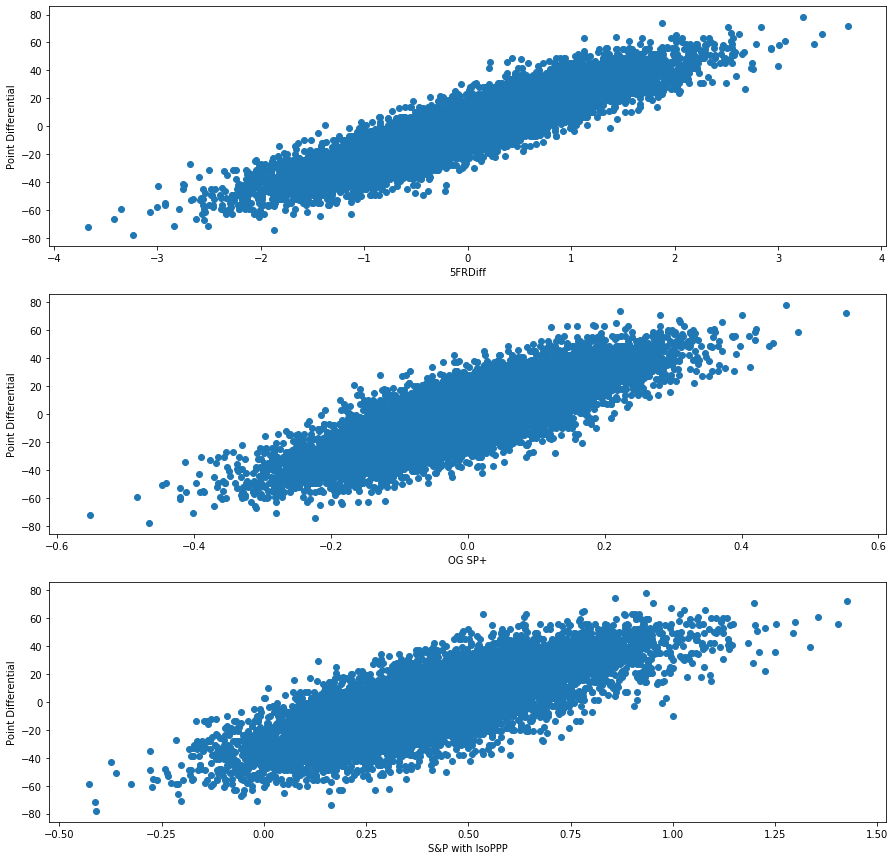

In [30]:
f, axes = plt.subplots(3, figsize=(15, 15))#plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

# for i in range(len(inputs)):
#     inpt = inputs[i]
axes[0].scatter(stored_game_boxes[f"5FRDiff"], stored_game_boxes.PtsDiff);
axes[0].set_xlabel("5FRDiff")
axes[0].set_ylabel("Point Differential");

axes[1].scatter(0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"], stored_game_boxes.PtsDiff);
axes[1].set_xlabel("OG SP+")
axes[1].set_ylabel("Point Differential");

axes[2].scatter(stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"], stored_game_boxes.PtsDiff);
axes[2].set_xlabel("S&P with IsoPPP")
axes[2].set_ylabel("Point Differential");

In [31]:
sp_isoppp = 0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"]
sp_eqppp = stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"]
correl = pd.DataFrame(data={"OGS&PDiff":sp_eqppp,"S&PIsoPPPDiff":sp_isoppp,"PtsDiff":stored_game_boxes.PtsDiff})
correl.corr()

,OGS&PDiff,S&PIsoPPPDiff,PtsDiff
OGS&PDiff,1.000000,0.911990,0.759463
S&PIsoPPPDiff,0.911990,1.000000,0.816783
PtsDiff,0.759463,0.816783,1.000000


In [32]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0.007186,0.388889,0.000000,0.200000,0.200000,0.000000,5.453906,0.907813,1.037223,1.907384
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,-0.007186,-0.388889,0.000000,-0.200000,-0.200000,0.000000,4.546094,-0.907813,1.037223,1.907384
2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.036359,-0.333333,-0.333333,-0.250000,-0.250000,0.333333,5.207552,0.415104,0.474277,0.181656
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.036359,0.333333,0.333333,0.250000,0.250000,-0.333333,4.792448,-0.415104,0.474277,0.181656
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.010417,-0.416667,-0.541667,-0.095238,-0.095238,-0.750000,4.744612,-0.510776,0.583588,0.499553


In [33]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.)]
msk = (np.random.rand(len(basis)) < 0.80)
train_data = basis[msk]
test_data = basis[~msk]

In [34]:
# outliers

In [35]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0.007186,0.388889,0.000000,0.200000,0.200000,0.000000,5.453906,0.907813,1.037223,1.907384
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,-0.007186,-0.388889,0.000000,-0.200000,-0.200000,0.000000,4.546094,-0.907813,1.037223,1.907384
2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.036359,-0.333333,-0.333333,-0.250000,-0.250000,0.333333,5.207552,0.415104,0.474277,0.181656
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.036359,0.333333,0.333333,0.250000,0.250000,-0.333333,4.792448,-0.415104,0.474277,0.181656
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.010417,-0.416667,-0.541667,-0.095238,-0.095238,-0.750000,4.744612,-0.510776,0.583588,0.499553


In [36]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"
    

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

In [37]:
model = LinearRegression().fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

# MAPE is not a trustworthy measurement when the mean's going to be near zero
# mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
# print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)

print(f'R-squared: {r2_score(test_data["PtsDiff"][:,np.newaxis], preds)}\n')
    
test.corr()

Linear Regression: y = 22.64775x + 0.00637
Mean Pred Score: 0.6600273185759208
Pred Std Dev: 19.460267441536597
Mean Abs Error: 7.549114050539238
Mdn Abs Error: 6.28535381481018
R-squared: 0.8077026853794822



,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,...,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.768196,0.586011,0.488092,0.793091,0.595779,0.589678,0.982655,0.539812,0.785916,...,0.538767,0.447340,0.225837,0.115261,0.040136,0.086805,0.208601,0.898738,0.898738,0.898738
OffSRDiff,0.768196,1.000000,0.491768,0.294796,0.701818,0.396192,0.412145,0.766062,0.752762,0.709273,...,0.545154,0.407235,0.191062,0.067922,0.001388,0.053037,0.119934,0.919073,0.919073,0.919073
OffERDiff,0.586011,0.491768,1.000000,0.154854,0.516773,0.299259,0.339256,0.577393,0.351852,0.811133,...,0.214812,0.193855,0.120100,0.030509,-0.002463,0.043624,0.056616,0.534621,0.534621,0.534621
FPDiff,0.488092,0.294796,0.154854,1.000000,0.605530,0.099294,0.081962,0.464238,0.072173,0.232724,...,0.274643,0.239089,0.316005,0.240669,0.167155,0.188119,0.170754,0.565186,0.565186,0.565186
OppRateDiff,0.793091,0.701818,0.516773,0.605530,1.000000,0.191308,0.189490,0.793719,0.297899,0.678234,...,0.513952,0.423843,0.223233,0.135248,0.006809,0.070692,0.238184,0.827865,0.827865,0.827865
OppEffDiff,0.595779,0.396192,0.299259,0.099294,0.191308,1.000000,0.744291,0.591258,0.509944,0.429061,...,0.290660,0.245176,0.106402,0.022183,0.050088,0.049882,0.356285,0.483164,0.483164,0.483164
OppPPDDiff,0.589678,0.412145,0.339256,0.081962,0.189490,0.744291,1.000000,0.600629,0.536785,0.464403,...,0.323185,0.258670,0.087539,0.013151,0.046692,0.058925,0.053135,0.533514,0.533514,0.533514
PPDDiff,0.982655,0.766062,0.577393,0.464238,0.793719,0.591258,0.600629,1.000000,0.531519,0.777556,...,0.542378,0.449623,0.225344,0.120474,0.037044,0.091429,0.198523,0.893207,0.893207,0.893207
OppSRDiff,0.539812,0.752762,0.351852,0.072173,0.297899,0.509944,0.536785,0.531519,1.000000,0.520089,...,0.369918,0.273663,0.150507,0.023862,0.005485,0.020332,-0.011519,0.674704,0.674704,0.674704
YPPDiff,0.785916,0.709273,0.811133,0.232724,0.678234,0.429061,0.464403,0.777556,0.520089,1.000000,...,0.455697,0.396273,0.157505,0.052073,-0.015107,0.026696,0.098363,0.753590,0.753590,0.753590


In [38]:
# Evaluating each factor
matx_factors = pd.DataFrame(data={
    'ActPtsDiff' : test_data['PtsDiff'],
    'ActPts' : test_data['Pts']
})
matx_factors['Eff'] = test_data.apply(lambda x: 0.35 * create_eff_index(x), axis=1)
matx_factors['Expl'] = test_data.apply(lambda x: 0.30 * create_expl_index(x), axis=1) 
matx_factors['FinDrv'] = test_data.apply(lambda x: 0.15 * create_finish_drive_index(x), axis=1) 
matx_factors['FldPos'] = test_data.apply(lambda x: 0.10 * create_fp_index(x), axis=1) 
matx_factors['Trnovr'] = test_data.apply(lambda x: 0.10 * create_turnover_index(x), axis=1) 
matx_factors['5FR'] = test_data['5FR']
matx_factors['5FRDiff'] = test_data['5FRDiff']
matx_factors['PredPtsDiff'] = preds
matx_factors.corr()

,ActPtsDiff,ActPts,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.759546,0.768196,0.728674,0.903487,0.488092,0.483598,0.898738,0.898738,0.898738
ActPts,0.759546,1.000000,0.581888,0.563582,0.690447,0.378438,0.373702,0.686085,0.686085,0.686085
Eff,0.768196,0.581888,1.000000,0.639929,0.796538,0.294796,0.267621,0.919073,0.919073,0.919073
Expl,0.728674,0.563582,0.639929,1.000000,0.697482,0.215034,0.226806,0.693339,0.693339,0.693339
FinDrv,0.903487,0.690447,0.796538,0.697482,1.000000,0.427131,0.422513,0.921981,0.921981,0.921981
FldPos,0.488092,0.378438,0.294796,0.215034,0.427131,1.000000,0.352174,0.565186,0.565186,0.565186
Trnovr,0.483598,0.373702,0.267621,0.226806,0.422513,0.352174,1.000000,0.474551,0.474551,0.474551
5FR,0.898738,0.686085,0.919073,0.693339,0.921981,0.565186,0.474551,1.000000,1.000000,1.000000
5FRDiff,0.898738,0.686085,0.919073,0.693339,0.921981,0.565186,0.474551,1.000000,1.000000,1.000000
PredPtsDiff,0.898738,0.686085,0.919073,0.693339,0.921981,0.565186,0.474551,1.000000,1.000000,1.000000


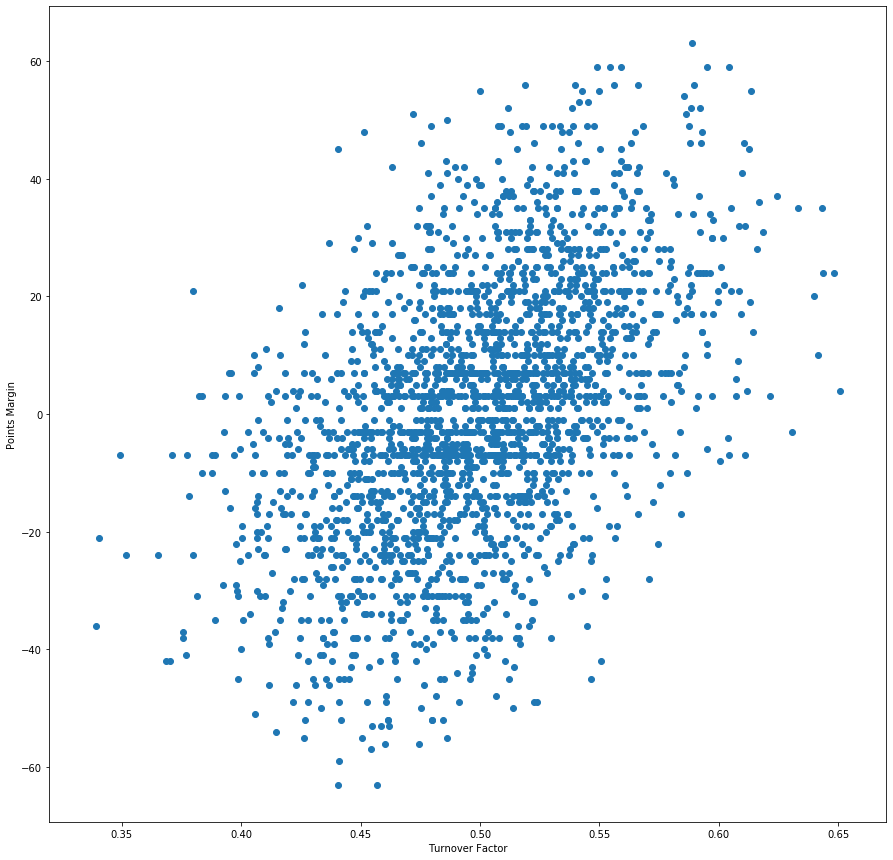

In [39]:
f, ax = plt.subplots(1, figsize=(15, 15))

ax.scatter(matx_factors["Trnovr"], matx_factors.ActPtsDiff);
ax.set_xlabel("Turnover Factor")
ax.set_ylabel("Points Margin");

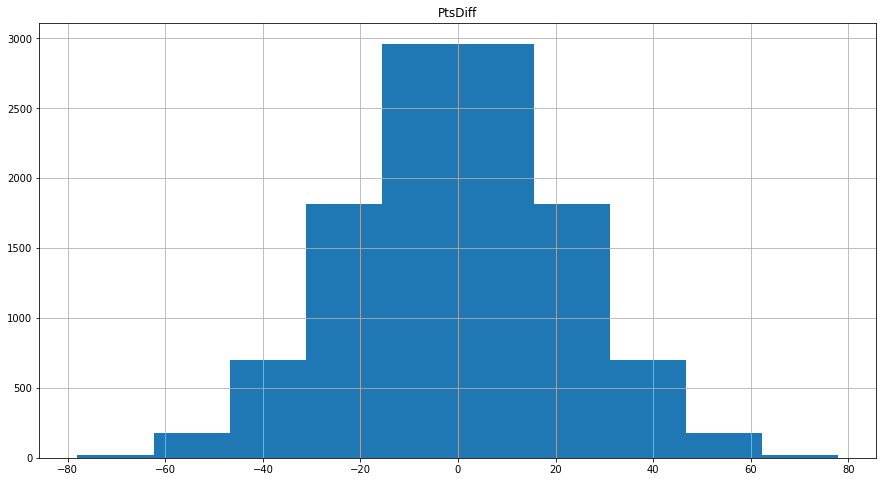

In [40]:
stored_game_boxes.hist(column='PtsDiff', figsize=(15,8));

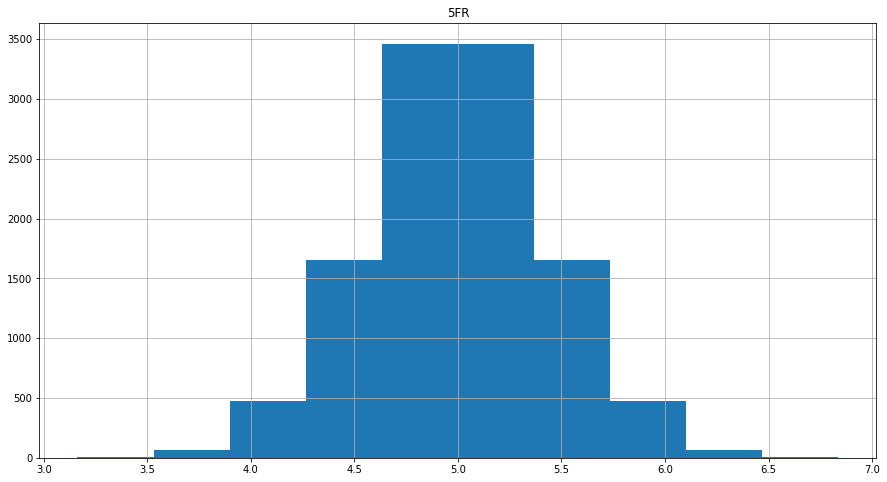

In [41]:
stored_game_boxes.hist(column='5FR', figsize=(15,8));

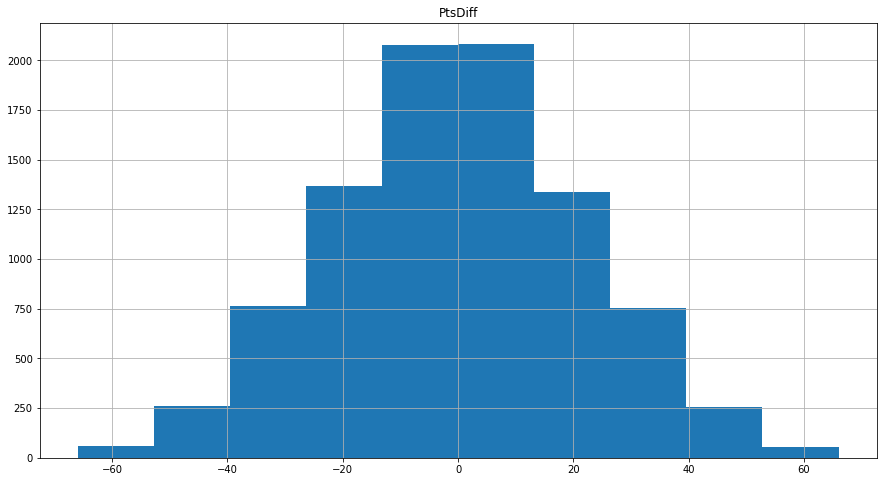

In [42]:
train_data.hist(column='PtsDiff', figsize=(15,8));

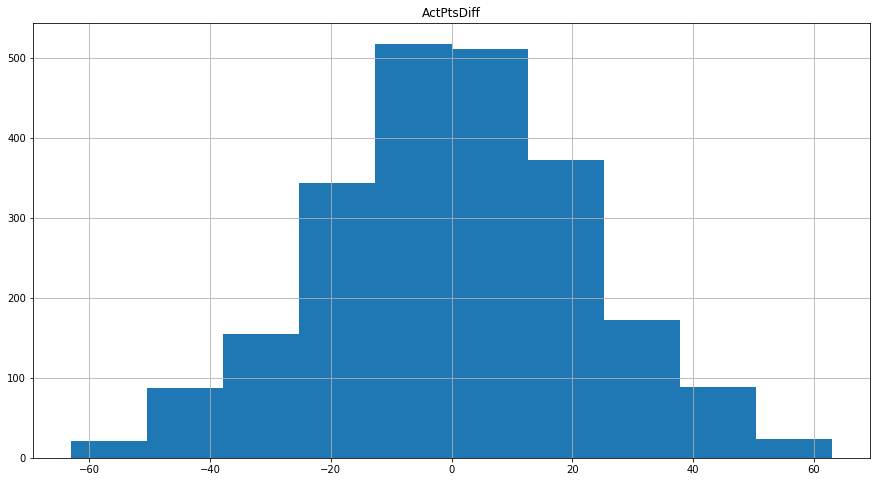

In [43]:
test.hist(column='ActPtsDiff', figsize=(15,8));

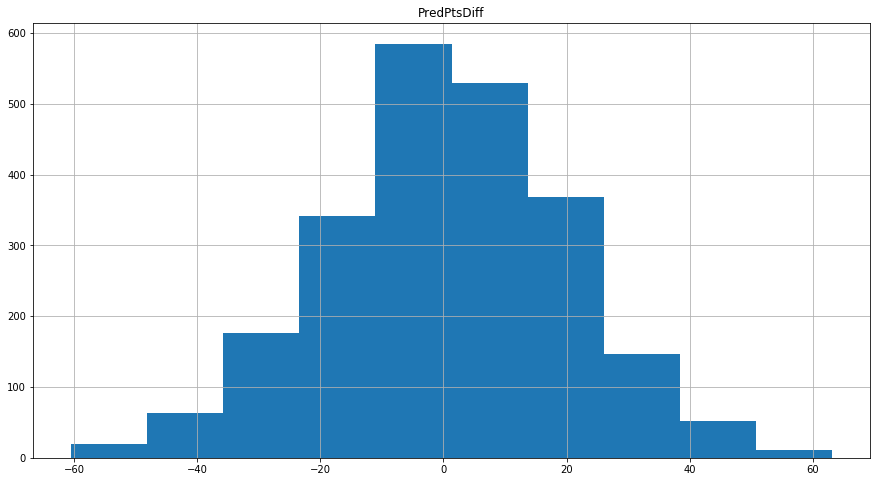

In [44]:
test.hist(column='PredPtsDiff', figsize=(15,8));

In [45]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    act_MOV = stringify_entry(max_box_row.PtsDiff)
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {act_MOV}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    win_prob = stats.norm.cdf(z)
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * win_prob):.2f}%")
    print("---")
    
    return [win_prob, act_MOV]

In [46]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -3.0 (exact value: -3.190052458375203)
Z score: -0.19784310716785905
Win Prob for Virginia Tech: 42.16%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.124959,-0.040309,-0.002715,0.0,0.166667,0.119048,0.119048,0.333333,5.070568,0.141137
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.124959,0.040309,0.002715,0.0,-0.166667,-0.119048,-0.119048,-0.333333,4.929432,-0.141137


In [47]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -11.0 (exact value: -11.294739935885408)
Z score: -0.6143166989033616
Win Prob for Georgia Tech: 26.95%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,0.396825,0.111111,5.460317,0.894136,...,-0.121075,0.018689,0.000768,0.0,0.0,0.166667,0.166667,0.0,4.750502,-0.498995
1,Miami,2019,401112488,21.0,-7.0,0.934248,0.370968,0.112903,5.790323,1.015211,...,0.121075,-0.018689,-0.000768,0.0,0.0,-0.166667,-0.166667,0.0,5.249498,0.498995


In [48]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by -1.0 (exact value: -0.5650444281042213)
Z score: -0.06295246200292762
Win Prob for Georgia Tech: 47.49%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,0.487500,0.150000,5.712500,0.704891,...,-0.300725,0.012719,0.0,-0.133333,0.066667,0.0,0.0,1.0,5.012615,0.025231
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,0.473684,0.140351,7.035088,1.005617,...,0.300725,-0.012719,0.0,0.133333,-0.066667,0.0,0.0,-1.0,4.987385,-0.025231


In [49]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by 4.0 (exact value: 3.527787469909262)
Z score: 0.14736488899491204
Win Prob for Mississippi State: 55.86%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,0.422535,0.070423,5.563380,0.880173,...,0.092249,0.000243,-0.004614,-0.666667,-0.333333,0.0,0.0,0,4.922257,-0.155486
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,0.413793,0.137931,5.482759,0.787924,...,-0.092249,-0.000243,0.004614,0.666667,0.333333,0.0,0.0,0,5.077743,0.155486


In [50]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -5.0 (exact value: -4.974488746574876)
Z score: -0.28953949795799366
Win Prob for Texas A&M: 38.61%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,0.466667,0.088889,5.511111,0.682602,...,-0.349878,0.001282,-0.047436,0.2,0.2,-0.25,-0.25,-0.25,5.109964,0.219927
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,0.423077,0.105769,4.634615,1.032480,...,0.349878,-0.001282,0.047436,-0.2,-0.2,0.25,0.25,0.25,4.890036,-0.219927


In [51]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    win_prob = stats.norm.cdf(z)
    return win_prob

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,Ohio State,0.940112,13,12.0,1.0
2,Clemson,0.933244,13,12.0,1.0
3,Alabama,0.908627,12,11.0,1.0
4,LSU,0.907024,13,12.0,1.0
5,Wisconsin,0.869616,13,11.0,2.0
6,Utah,0.839239,13,11.0,2.0
7,Oklahoma,0.821432,13,11.0,2.0
8,Oregon,0.807623,13,10.0,3.0
9,Appalachian State,0.792059,13,10.0,3.0
10,Georgia,0.783841,13,10.0,3.0


In [52]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

,team,second_order_wins,second_order_losses
77,Ohio State,11.473664,1.526336
21,Clemson,10.569822,2.430178
53,LSU,10.341624,2.658376
128,Wisconsin,9.567188,3.432812
2,Alabama,9.275826,2.724174
115,Utah,9.115056,3.884944
78,Oklahoma,9.004087,3.995913
3,Appalachian State,8.675959,4.324041
82,Oregon,8.674563,4.325437
34,Georgia,8.465277,4.534723


In [53]:
# Matchup Predictor?
grouped_by_year = stored_game_boxes.copy().groupby(['Team','Season'])
ratings = grouped_by_year.apply(lambda x: x['5FR'].mean())
team_fr_year = ratings.reset_index()
team_fr_year.columns = ["Team",'Season','5FR']
team_fr_year

tmp = team_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FR', ascending=False)).reset_index(drop=True)
team_strength = pd.DataFrame()
for yr in range(2012, 2020):
    retrieve = tmp[tmp.Season == yr].copy()
    retrieve['Rank'] = range(1, len(retrieve)+1)
    team_strength = team_strength.append(retrieve)
team_strength

,Team,Season,5FR,Rank
0,Alabama,2012,5.557889,1
1,Florida State,2012,5.454605,2
2,BYU,2012,5.335653,3
3,Arizona State,2012,5.333539,4
4,Oklahoma,2012,5.331083,5
5,Fresno State,2012,5.309021,6
6,Georgia,2012,5.304040,7
7,Notre Dame,2012,5.289858,8
8,Utah State,2012,5.267835,9
9,Kansas State,2012,5.266560,10


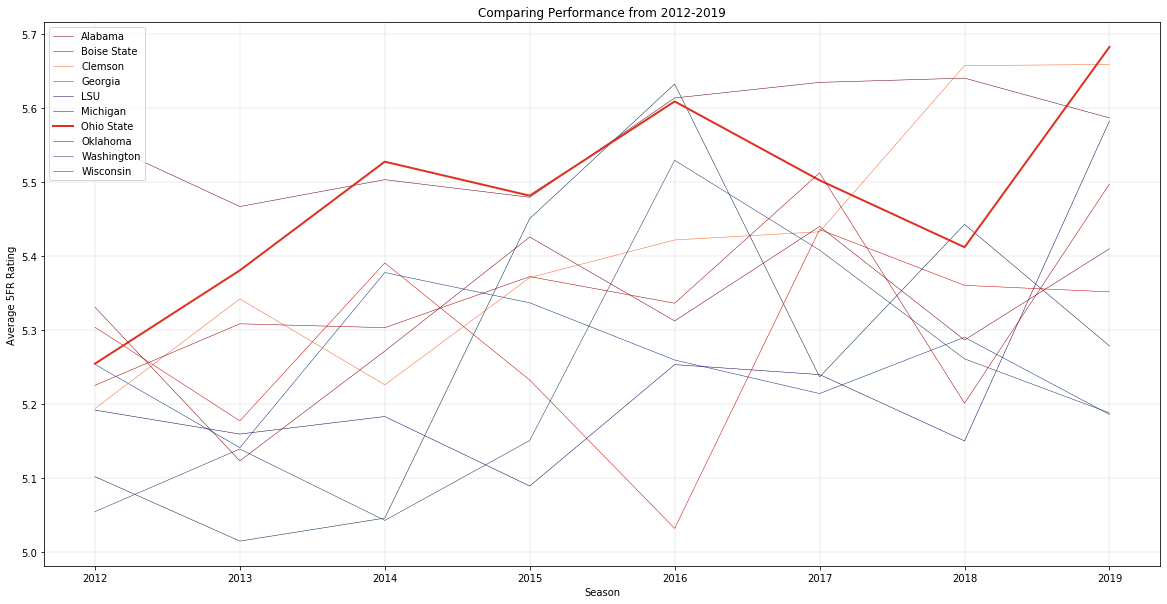

In [54]:
# Graph team progression
def retrieve_ratings_chart(team, highlight_team = None):
    fig, ax = plt.subplots(1, figsize=(20,10))
    ax.grid(linestyle='-', linewidth=0.25)
    ax.set_xlabel('Season');
    ax.set_ylabel('Average 5FR Rating')
    if (isinstance(team, str)):
        school_ratings = team_strength[team_strength.Team == team]
        team_info = teams[teams.school == team]
    else:
        school_ratings = team_strength[team_strength.Team.isin(team)]
        team_info = teams[teams.school.isin(team)]
        
    opacity = 1.0
    for idx, item in team_info.iterrows():
        if ((item.school == highlight_team) & (highlight_team != None)):
            opacity = 2.0
        elif ((item.school != highlight_team) & (highlight_team != None)):
            opacity = 0.5
        else:
            opacity = 1.0
        ax.plot(school_ratings[school_ratings.Team == item.school].Season, school_ratings[school_ratings.Team == item.school]['5FR'], color=item.color,label=item.school, linewidth=opacity)
    
#     ax.plot(school_ratings.Season, np.full(len(school_ratings.Season), 5), color='y',label="National Average")
    ax.set_title(f"Comparing Performance from {min(school_ratings.Season)}-{max(school_ratings.Season)}")
    ax.legend()
    return ax
retrieve_ratings_chart(["Alabama","Ohio State","Clemson","Wisconsin","Oklahoma","Georgia","Michigan","Boise State","LSU","Washington"], highlight_team = "Ohio State");

In [55]:
# Rank teams by avg strength rating from 2012-19
strength_ranks = team_strength.copy().groupby(['Team']).apply(lambda x: x['5FR'].mean()).sort_values(ascending=False)
strength_ranks = strength_ranks.reset_index()
strength_ranks.columns = ["Team",'Avg5FR']
strength_ranks

,Team,Avg5FR
0,Alabama,5.560512
1,Ohio State,5.481456
2,Clemson,5.413149
3,Wisconsin,5.344711
4,Oklahoma,5.325188
5,Georgia,5.285696
6,Michigan,5.275654
7,Boise State,5.257562
8,LSU,5.231349
9,Washington,5.221882


In [56]:
strength_max = team_strength.sort_values(by='5FR', ascending=False)
strength_max.head(10)

,Team,Season,5FR,Rank
900,Ohio State,2019,5.682812,1
127,Florida State,2013,5.667090,1
901,Clemson,2019,5.659044,2
770,Clemson,2018,5.657551,1
771,Alabama,2018,5.640608,2
640,Alabama,2017,5.634880,1
512,Michigan,2016,5.632687,1
513,Alabama,2016,5.613788,2
514,Ohio State,2016,5.609128,3
902,Alabama,2019,5.586845,3


In [57]:
strength_max[strength_max.Team == "Georgia Tech"]

,Team,Season,5FR,Rank
280,Georgia Tech,2014,5.189151,25
65,Georgia Tech,2012,5.002690,66
194,Georgia Tech,2013,4.998730,68
844,Georgia Tech,2018,4.984770,75
727,Georgia Tech,2017,4.918923,88
592,Georgia Tech,2016,4.894851,81
473,Georgia Tech,2015,4.827962,90
1018,Georgia Tech,2019,4.620667,119


In [58]:
def filter_opponents(box, team):
    return box[box.Team != team].Team.tolist()[0]

# grouped_by_team = stored_game_boxes.groupby(['GameID'])
opponent_game_ids = pd.DataFrame()
for team in team_list:
    for yr in range(2012, 2020):
        team_games = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == yr)].GameID.to_list()
        for idx, item in enumerate(team_games, start=1):
            box = stored_game_boxes[stored_game_boxes.GameID == item]
            opp = filter_opponents(box, team)
            opponent_game_ids = opponent_game_ids.append({'GameID' : item, 'Team':team,'Opponent':opp,'Season':stringify_entry(box.Season), 'Week': idx}, ignore_index=True)
opponent_game_ids

,GameID,Opponent,Season,Team,Week
0,322520130.0,Michigan,2012.0,Air Force,1.0
1,322662439.0,UNLV,2012.0,Air Force,2.0
2,322732005.0,Colorado State,2012.0,Air Force,3.0
3,322802005.0,Navy,2012.0,Air Force,4.0
4,322872751.0,Wyoming,2012.0,Air Force,5.0
5,322942005.0,New Mexico,2012.0,Air Force,6.0
6,323002005.0,Nevada,2012.0,Air Force,7.0
7,323080349.0,Army,2012.0,Air Force,8.0
8,323150021.0,San Diego State,2012.0,Air Force,9.0
9,323212005.0,Hawai'i,2012.0,Air Force,10.0


In [59]:
def predict_matchup(team1, team2, year, week = -1, games_to_consider = 4):
    # Start with some default values
    natl_avg = team_strength[(team_strength.Season == year)]['5FR'].mean()
    fcs = team_strength[(team_strength.Season == year)].quantile(.02)['5FR'] # assume any/all FCS team is only as good as the bottom 2% of FBS
    if (games_to_consider <= 0):
        games_to_consider = 16 # consider all games
    
    if (week <= 0):
        week = 16 # consider all weeks
    
    # Generate comparison attributes for team 1
    team1_avg_ffr = grouped_by_year.get_group((team1, year))[:week]['5FR'].tail(games_to_consider).mean() if ((team1, year) in grouped_by_year.groups) else natl_avg
    team1_sos = natl_avg
    team1_opps = opponent_game_ids[(opponent_game_ids.Team == team1) & (opponent_game_ids.Week < week)][:week].Opponent.to_list()
    team1_record = teams[(teams.school == team1)]
    team1_conf = stringify_entry(team1_record.conference)
    team1_conf_teams = teams[teams.conference == team1_conf].school.to_list()

    if ~(team1_record.conference.isin(fbs).any()):
        team1_avg_ffr = fcs
        team1_sos = fcs
        team1_conf_sos = fcs
        team1_subdiv_sos = fcs
    else:
        team1_sos = team_strength[(team_strength.Team.isin(team1_opps)) & (team_strength.Season == year)]['5FR'].mean()
        team1_conf_sos = team_strength[(team_strength.Team.isin(team1_conf_teams)) & (team_strength.Season == year)]['5FR'].mean()
        team1_p5 = (stringify_entry(team1_record.conference) in p5)
        team1_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team1_p5)].school.to_list()
        team1_subdiv_sos = team_strength[(team_strength.Team.isin(team1_subdiv_members)) & (team_strength.Season == year)]['5FR'].mean()

    # Generate comparison attributes for team 2
    team2_avg_ffr = grouped_by_year.get_group((team2, year))[:week]['5FR'].tail(games_to_consider).mean() if ((team2, year) in grouped_by_year.groups) else natl_avg
    team2_sos = natl_avg
    team2_record = teams[(teams.school == team2)]
    team2_conf = stringify_entry(team2_record.conference)
    team2_conf_teams = teams[teams.conference == team2_conf].school.to_list()
    team2_opps = opponent_game_ids[(opponent_game_ids.Team == team2) & (opponent_game_ids.Week < week)][:week].Opponent.to_list()
    if ~(team2_record.conference.isin(fbs).any()):
        team2_avg_ffr = fcs
        team2_sos = fcs
        team2_conf_sos = fcs
        team2_subdiv_sos = fcs
    else:
        team2_sos = team_strength[(team_strength.Team.isin(team2_opps)) & (team_strength.Season == year)]['5FR'].mean()
        team2_conf_sos = team_strength[(team_strength.Team.isin(team2_conf_teams)) & (team_strength.Season == year)]['5FR'].mean()
        team2_p5 = (stringify_entry(team2_record.conference) in p5)
        team2_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team2_p5)].school.to_list()
        team2_subdiv_sos = team_strength[(team_strength.Team.isin(team2_subdiv_members)) & (team_strength.Season == year)]['5FR'].mean()
    
    # adjust based on fcs vs fbs AND overall strength of schedule
    if (team2_sos < team1_sos):
        team2_avg_ffr *= (team2_sos / team1_sos)
    elif (team2_sos > team1_sos):
        team1_avg_ffr *= (team1_sos / team2_sos)
        
    # adjust based on p5 vs g5
    if (team2_subdiv_sos < team1_subdiv_sos):
        team2_avg_ffr *= (team2_subdiv_sos / team1_subdiv_sos)
    elif (team2_subdiv_sos > team1_subdiv_sos):
        team1_avg_ffr *= (team1_subdiv_sos / team2_subdiv_sos)
        
    # adjust based on conference SoS
    if (team2_conf_sos < team1_conf_sos):
        team2_avg_ffr *= (team2_conf_sos / team1_conf_sos)
    elif (team2_conf_sos > team1_conf_sos):
        team1_avg_ffr *= (team1_conf_sos / team2_conf_sos)
    
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
    pred = model.predict([[ffr_diff]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, pred[0]]

predict_matchup('Georgia Tech', 'Clemson', 2019, 0, -1)

[0.13758797206658768, -20.57541214918198]

In [60]:
team_triples = [
#     ['Buffalo', 'Charlotte', 7], # Buff 31, Char 9
#     ['Utah State', 'Kent State', 7], # Kent 51, Utah 41
#     ['San Diego State', 'Central Michigan', 3.5], # SDSU 48, CMU 11
#     ['Georgia Southern','Liberty', 4.5], # Lib 23, GASO 16
#     ['SMU','Florida Atlantic', 7], # FAU 52, SMU 28
#     ['Florida International','Arkansas State', 1], # ArkSt 34, FIU 28
#     ['Washington', 'Boise State', 3.5], # Wash 38, Boise 7
#     ['Appalachian State', 'UAB', 17], # App 31, UAB 17
#     ['UCF','Marshall',15], # UCF 48, Marshall 25
#     ['BYU',"Hawai'i",2], # Hawaii 38, BYU 34
#    ----- 7-3 SU / 5-5 ATS ------
#     ['Miami','Louisiana Tech',6], # LaTech 14, Miami 0
#     ['Pittsburgh','Eastern Michigan',11], # Pitt 34, EMU 30
#    ----- 8-4 SU / 6-6 ATS ------ 
#     ['North Carolina','Temple',5], # UNC 55, Temple 13
#     ['Michigan State','Wake Forest',3.5], # MichSt 27, Wake 21
#     ['Texas A&M', 'Oklahoma State', 7], # TAMU 24, OKST 21
#     ['Iowa', 'USC', 2.5], # Iowa 48, USC 24
#     ['Air Force', 'Washington State', 3], # AFA 31, Wazzu 21
#    ----- 12-5 SU / 9-8 ATS ------ 
#     ['Penn State','Memphis',7], # Cotton Bowl - PennSt 53, Memphis 39
#     ['Notre Dame', 'Iowa State', 4], # ND 33, IAST 9
#    ----- 13-6 SU / 10-9 ATS ------ 
#     ['LSU','Oklahoma',11], # CFP Semifinal: Peach Bowl: LSU 63, OU 28
#    ----- 14-6 SU / 10-10 ATS ------ 
#     ['Clemson','Ohio State',2.5], # CFP Semifinal: Fiesta Bowl: CLEM 29, OhioSt 23
#    ----- 15-6 SU / 11-10 ATS ------ 
#     ['Western Kentucky', 'Western Michigan', 3.5], # WKU 23, WMU 20
#     ['Mississippi State', 'Louisville', 4], # LOU 38, MSST 28
#     ['California', 'Illinois', 6.5], # Cal 35, Ill 20
#    ----- 17-7 SU / 12-12 ATS ------     
#     ['Florida','Virginia',14], # Orange Bowl # UF 36, UVA 28
#    ----- 18-7 SU / 13-12 ATS ------     
#     ['Virginia Tech', 'Kentucky', 3], # Kentucky 37, VT 30
#    ----- 18-8 SU / 13-13 ATS ------    
#     ['Arizona State', 'Florida State', 4],
#    ----- 19-8 SU / 14-13 ATS ------  
#     ['Navy', 'Kansas State', 2],
#    ----- 20-8 SU / 15-13 ATS ------  
#     ['Wyoming', 'Georgia State', 7],
#    ----- 21-8 SU / 15-14 ATS ------  
#     ['Utah', 'Texas', 7],
#    ----- 21-9 SU / 16-14 ATS ------     
#     ['Auburn', 'Minnesota', 7.5], # Minnesota 31, Auburn 24
#     ['Alabama', 'Michigan', 7], # Bama 35, Mich 16
#    ----- 23-9 SU / 17-15 ATS ------    
#     ['Wisconsin','Oregon',2.5], # Rose Bowl - Oregon 28, Wisc 27
#    ----- 23-10 SU / 18-15 ATS ------  
#     ['Georgia','Baylor',7.5], # Sugar Bowl - uga 26, Baylor 14
#    ----- 23-11 SU / 18-16 ATS ------      
#     ['Cincinnati', 'Boston College',7], # Cincy 38, BC 6
#    ----- 23-12 SU / 18-17 ATS ------    
#     ['Tennessee', 'Indiana', 1.5], # Tennessee 23, Indiana 22
#    ----- 23-13 SU / 19-17 ATS ------        
#     ['Ohio', 'Nevada', 7.5], # Ohio 30, Nevada 21
#    ----- 24-13 SU / 19-18 ATS ------     
#     ['Tulane', 'Southern Mississippi', 7], # Tulane 30, Southern Miss 13
#    ----- 24-14 SU / 19-19 ATS ------     
#     ['Louisiana', 'Miami (OH)', 14] # Louisiana 27, Miami 17
#    ----- 24-15 SU / 19-20 ATS ------  
    ["LSU", "Clemson", 6]
]

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
    
bets #.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,favorite,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick
0,LSU,Clemson,6,-2.004432,0.445548,False,Clemson,Clemson


In [61]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by 0.0 (exact value: 0.28273895249640946)
Z score: -0.01938762492411668
Win Prob for Virginia: 49.23%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30.0,-9.0,0.577256,0.432432,0.162162,6.540541,1.169095,...,-0.403644,-0.089435,-0.044717,0.25,0.125,0.333333,0.333333,0.0,4.993899,-0.012203
1,Virginia,2019,401112521,39.0,9.0,0.422744,0.381818,0.181818,8.872727,1.572739,...,0.403644,0.089435,0.044717,-0.25,-0.125,-0.333333,-0.333333,0.0,5.006101,0.012203


In [62]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 11.0 (exact value: 10.502347383312507)
Z score: 0.5057648921992117
Win Prob for North Carolina: 69.35%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,0.457447,0.106383,5.744681,0.811309,...,-0.235394,0.079888,0.037736,0.238095,0.380952,-0.214286,-0.214286,0.5,5.231722,0.463445
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,0.396226,0.150943,6.094340,1.046703,...,0.235394,-0.079888,-0.037736,-0.238095,-0.380952,0.214286,0.214286,-0.5,4.768278,-0.463445


In [63]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 19.0 (exact value: 18.999781644349188)
Z score: 0.9424204667726368
Win Prob for Pittsburgh: 82.70%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,0.362319,0.057971,5.086957,0.882151,...,-0.248736,0.038746,0.026324,0.0,0.0,0.0,0.0,0.166667,5.419322,0.838645
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,0.204082,0.061224,3.591837,1.130888,...,0.248736,-0.038746,-0.026324,0.0,0.0,0.0,0.0,-0.166667,4.580678,-0.838645


In [64]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -10.0 (exact value: -9.664778841671012)
Z score: -0.5305582870978097
Win Prob for Auburn: 29.79%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Alabama,2019,401110865,45.0,-3.0,0.400109,0.453333,0.133333,6.440000,0.905516,...,-0.083465,-0.033763,-0.013333,0.053571,0.160714,-0.666667,-0.666667,-0.5,5.213512,0.427025
1,Auburn,2019,401110865,48.0,3.0,0.599891,0.338710,0.112903,5.322581,0.988981,...,0.083465,0.033763,0.013333,-0.053571,-0.160714,0.666667,0.666667,0.5,4.786488,-0.427025


In [65]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

Game: Georgia @ Georgia Tech
Actual Winner: Georgia
MOV: Georgia by 45.0
Proj MOV: Georgia by 34.0 (exact value: 34.08546690485794)
Z score: 1.7176248829416252
Win Prob for Georgia: 95.71%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Georgia,2019,401110867,52.0,45.0,0.998507,0.472222,0.138889,6.847222,0.969971,...,0.455922,0.020115,0.003352,0.888889,-0.111111,0.461538,0.461538,0.5,5.752373,1.504745
1,Georgia Tech,2019,401110867,7.0,-45.0,0.001493,0.224138,0.034483,2.396552,0.514049,...,-0.455922,-0.020115,-0.003352,-0.888889,0.111111,-0.461538,-0.461538,-0.5,4.247627,-1.504745


In [66]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row, year):
    prob = generate_win_prob(row.GameID, year)[0]
    return prob if row.ActualMOV > 0 else 1-prob

def clean_prediction_prob(row, team, year, idx):
    parts = row.Team.tolist()
    prob = predict_matchup(parts[1],parts[0], year, idx)[0] if idx > 0 else predict_matchup(parts[1],parts[0], year-1, -1)[0]
    return prob if team == parts[1] else 1-prob

def clean_prediction_mov(row, team, year, idx):
    parts = row.Team.tolist()
    mov = predict_matchup(parts[1],parts[0], year, idx)[1] if idx > 0 else predict_matchup(parts[1],parts[0], year-1, -1)[1]
    return mov if team == parts[1] else -1*mov

def generate_schedule_analysis(team, year):
    game_ids = games[((games.home_team == team) | (games.away_team == team)) & (games.season == year)].id
    frame = pd.DataFrame(data={"GameID":game_ids,"Year":year})
    frame.reset_index(inplace=True, drop=True)
    frame['Team'] = team
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob(calculate_box_score(y.GameID, year),team, year, y.name) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov(calculate_box_score(y.GameID, year),team, year, y.name), axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x, year) * 100, axis=1)
    return frame

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 22.0 (exact value: 21.57916026823397)
Z score: 1.0749663647996741
Win Prob for Clemson: 85.88%
---
Game: South Florida @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 4.0
Proj MOV: Georgia Tech by 9.0 (exact value: 9.488479286134197)
Z score: 0.4536655004398632
Win Prob for Georgia Tech: 67.50%
---
Game: The Citadel @ Georgia Tech
Actual Winner: The Citadel
MOV: The Citadel by 3.0
Proj MOV: The Citadel by -10.0 (exact value: -10.491074638418468)
Z score: -0.5730189469643737
Win Prob for The Citadel: 28.33%
---
Game: Georgia Tech @ Temple
Actual Winner: Temple
MOV: Temple by 22.0
Proj MOV: Temple by 21.0 (exact value: 20.812227531524968)
Z score: 1.0355561799698378
Win Prob for Temple: 84.98%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 11.0 (exact value: 10.502347383312507)
Z score: 0.5057648921992

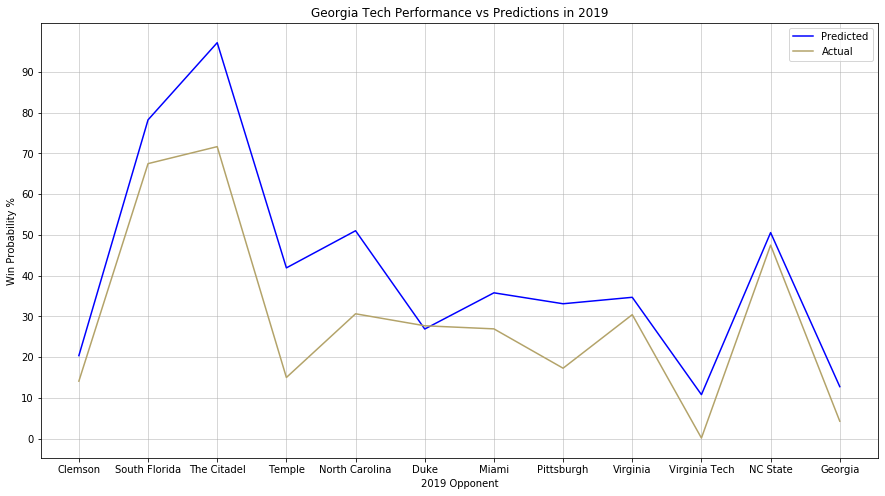

In [67]:
gatech_results = generate_schedule_analysis("Georgia Tech", 2019)
gatech_results
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredWinProb, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.PostGameWinProb, color='#B3a369', label="Actual")
plt.yticks(np.arange(0, 100, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Win Probability %')
plt.legend();

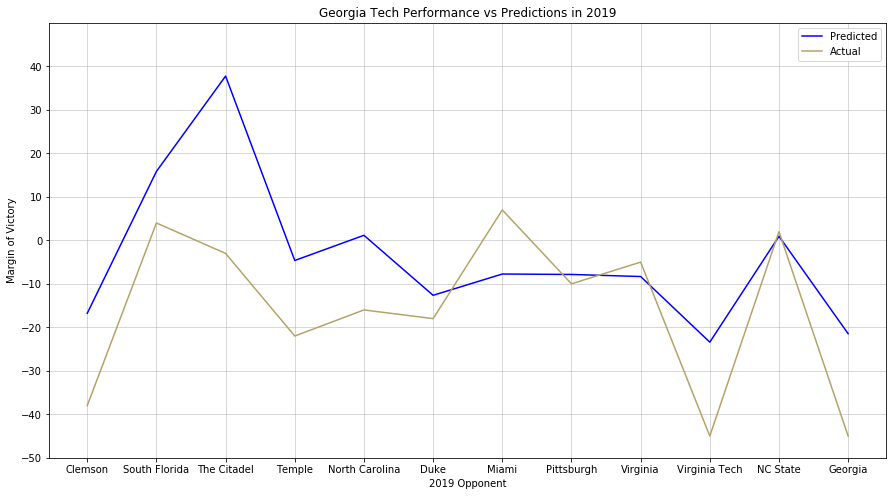

In [68]:
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredMOV, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.ActualMOV, color='#B3a369', label="Actual")
plt.ylim((-50,50))
plt.yticks(np.arange(-50, 50, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Margin of Victory');
plt.legend();

Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 41.0
Proj MOV: Georgia Tech by 40.0 (exact value: 40.038027720835146)
Z score: 2.0235076686669577
Win Prob for Georgia Tech: 97.85%
---
Game: Georgia Tech @ South Florida
Actual Winner: South Florida
MOV: South Florida by 11.0
Proj MOV: South Florida by 8.0 (exact value: 8.258393104434049)
Z score: 0.3904553628918758
Win Prob for South Florida: 65.19%
---
Game: Georgia Tech @ Pittsburgh
Actual Winner: Pittsburgh
MOV: Pittsburgh by 5.0
Proj MOV: Pittsburgh by 7.0 (exact value: 7.14965435865167)
Z score: 0.3334808763328755
Win Prob for Pittsburgh: 63.06%
---
Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 28.0
Proj MOV: Clemson by 35.0 (exact value: 34.64404874935849)
Z score: 1.7463285914686877
Win Prob for Clemson: 95.96%
---
Game: Bowling Green @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 46.0
Proj MOV: Georgia Tech by 38.0 (exact value: 38.345109048014564)
Z score

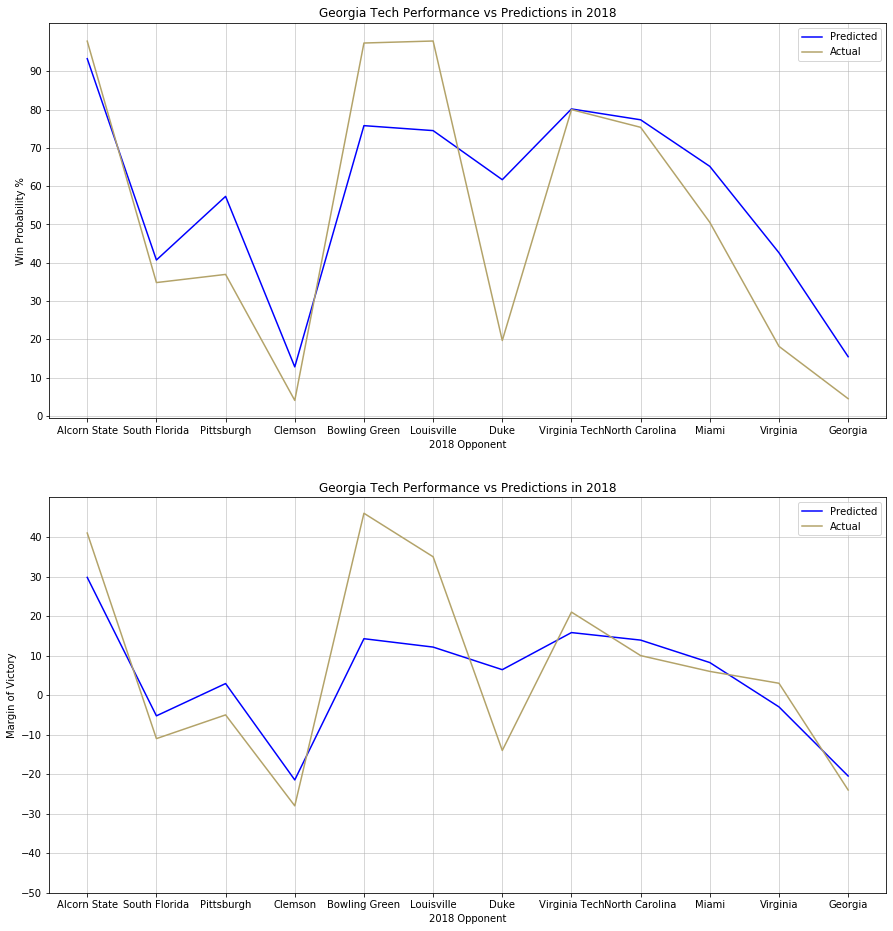

In [69]:
gatech_18_results = generate_schedule_analysis("Georgia Tech", 2018)
fig, axes = plt.subplots(2, figsize=(15,16))

axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PredWinProb, color='b', label="Predicted")
axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].plot(gatech_18_results.Opponent, gatech_18_results.PredMOV, color='b', label="Predicted")
axes[1].plot(gatech_18_results.Opponent, gatech_18_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

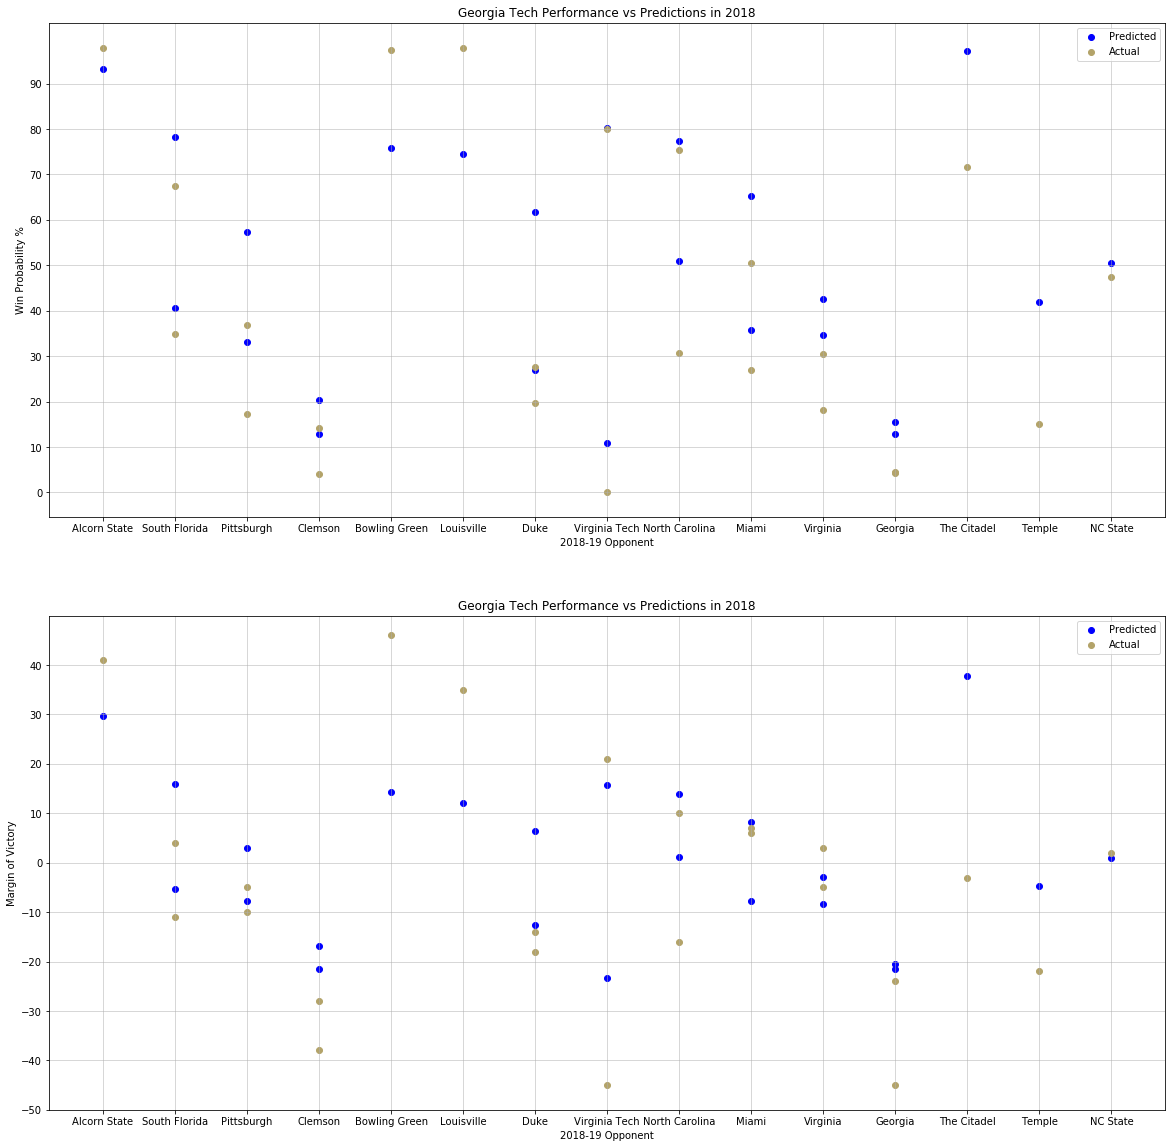

In [70]:
gatech_1819_results = gatech_18_results.append(gatech_results)
fig, axes = plt.subplots(2, figsize=(20,20))
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredWinProb, color='b', label="Predicted")
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018-19 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredMOV, color='b', label="Predicted")
axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018-19 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

In [71]:
# Stability of 5FR measure YoY
grouped_by_season = stored_game_boxes.copy().groupby(['Season', 'Team'])
tings = grouped_by_season.apply(lambda x: x['5FR'].mean())
team_fr_szn = ratings.reset_index()
team_fr_szn.columns = ["Team",'Season','5FRMean']
team_fr_szn

pivot = team_fr_szn.pivot_table(values='5FRMean', index='Team', columns='Season').reset_index()
pivot.corr()

Season,2012,2013,2014,2015,2016,2017,2018,2019
Season,,,,,,,,
2012,1.000000,0.588419,0.525922,0.451708,0.382888,0.294932,0.300102,0.363724
2013,0.588419,1.000000,0.562660,0.366535,0.245886,0.260429,0.185906,0.279529
2014,0.525922,0.562660,1.000000,0.616191,0.486516,0.332863,0.332074,0.386088
2015,0.451708,0.366535,0.616191,1.000000,0.656791,0.472449,0.379352,0.403569
2016,0.382888,0.245886,0.486516,0.656791,1.000000,0.602822,0.417091,0.594267
2017,0.294932,0.260429,0.332863,0.472449,0.602822,1.000000,0.634953,0.569375
2018,0.300102,0.185906,0.332074,0.379352,0.417091,0.634953,1.000000,0.610008
2019,0.363724,0.279529,0.386088,0.403569,0.594267,0.569375,0.610008,1.000000


In [72]:
def clean_prediction_prob_names(row):
    prob = predict_matchup(row.Team, row.Opponent, row.Year - 1, -1, -1)[0]
    return prob

def clean_prediction_mov_names(row):
    mov = predict_matchup(row.Team, row.Opponent, row.Year - 1, -1, -1)[1]
    return mov

def generate_schedule_predictions(team, opponents = pd.DataFrame(), year = 2019):
    frame = pd.DataFrame(data={"Year":year,"Team":team,"Opponent":opponents.Team, "Site":opponents.Site})
    frame.reset_index(inplace=True, drop=True)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob_names(y) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov_names(y), axis=1)
    return frame


opp_2020_df = pd.DataFrame(data={
    "Team" : ["UCF","Auburn","James Madison","Connecticut","Boston College","Duke","Miami","Georgia Tech","NC State","Pittsburgh","Virginia Tech","Virginia"],
    "Site" : ["Away","Home","Home","Home","Away","Away","Away","Home","Home","Home","Home","Away"]
})
georgia_tech_2020 = generate_schedule_predictions("North Carolina", opp_2020_df, 2020)
georgia_tech_2020

,Year,Team,Opponent,Site,PredWinProb,PredMOV
0,2020,North Carolina,UCF,Away,35.617325,-6.515100
1,2020,North Carolina,Auburn,Home,28.407391,-10.447532
2,2020,North Carolina,James Madison,Home,97.638745,39.274565
3,2020,North Carolina,Connecticut,Home,74.208025,13.304765
4,2020,North Carolina,Boston College,Away,44.852760,-1.857786
5,2020,North Carolina,Duke,Away,47.366876,-0.625335
6,2020,North Carolina,Miami,Away,36.522141,-6.044746
7,2020,North Carolina,Georgia Tech,Home,58.819511,4.997810
8,2020,North Carolina,NC State,Home,54.958382,3.084970
9,2020,North Carolina,Pittsburgh,Home,47.037164,-0.786565


In [73]:
generate_win_prob(401135288, 2019)
box2 = calculate_box_score(401135288, 2019)
# testDiffs = ["Team",'5FRDiff']
# print(box2[["Team","FP","FPDiff"]])
break_down_box_score(box2)

Could not find basic game data for game_id 401135288 locally, checking CFB Data API
Could not find drive data for game_id 401135288 locally, checking CFB Data API
Could not find play by play data for game_id 401135288 locally, checking CFB Data API
Game: Oregon @ Wisconsin
Actual Winner: Oregon
MOV: Oregon by 1
Proj MOV: Oregon by 4.0 (exact value: 4.050170192848693)
Z score: 0.17420844212226735
Win Prob for Oregon: 56.91%
---
Could not find basic game data for game_id 401135288 locally, checking CFB Data API
Could not find drive data for game_id 401135288 locally, checking CFB Data API
Could not find play by play data for game_id 401135288 locally, checking CFB Data API


,Team,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff
0,Oregon,5.114379,4.961943,4.87236,5.115385,5.68268,5.089276,0.178552
1,Wisconsin,4.885621,5.038057,5.12764,4.884615,4.31732,4.910724,-0.178552


In [74]:
predict_matchup("Oregon","Wisconsin", 2012, -1)

[0.3995119059044526, -4.29476455065851]

In [75]:
line_data = pd.DataFrame()

for i in range(2013, 2020):
    ln = retrieveCfbDataFile('lines',i)
    ln['year'] = i
    line_data = line_data.append(ln, sort=False)
    
print(f"Spreads imported: {len(line_data)}")

Spreads imported: 17274


In [76]:
def assign_favorite(row):
    if (row.RawSpread < 0):
        return row.HomeTeam
    else:
        return row.AwayTeam

def simplify_prediction_names_prob(row):
#     print(row.GameID)
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = int(weeks[0]) if (len(weeks) > 0) else -1
    prob = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week)[0]
    return prob

def simplify_prediction_names_mov(row):
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = int(weeks[0]) if (len(weeks) > 0) else -1
    mov = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week)[1]
    return mov
    
def determine_ml_win(row):
    winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.MLPick) else "No"

def determine_ats_win(row):
    mov = (row.HomeScore - row.AwayScore) if (row.Favorite == row.HomeTeam) else (row.AwayScore - row.HomeScore)
    if (row.RawSpread < 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.HomeTeam if (mov > row.BetMOV) else row.AwayTeam
    elif (row.RawSpread > 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.AwayTeam if (mov > row.BetMOV) else row.HomeTeam
    else:
        winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.ATSPick) else "No"

# Notes: no betting data for 2012, no box scores for 2014
def simulate_season(year):
    print(f"[Simulation] Retrieving box score entries for {year} season...")
    game_ids = stored_game_boxes[(stored_game_boxes.Season == year)].GameID.drop_duplicates().to_list()
    print(f"[Simulation] Retrieved {len(game_ids)} box scores for {year} season, pulling betting lines...")
    lines = line_data[(line_data.year == year) & (line_data.lineProvider == 'consensus') & (line_data.id.isin(game_ids))]
    print(f"[Simulation] Retrieved {len(lines)} games with betting lines for {year} season.")
    print(f"[Simulation] Creating projections for {len(lines)} games and analyzing spreads...")
    produced = pd.DataFrame(data={"GameID" : lines.id, "Season": year,"HomeTeam": lines.homeTeam,"HomeScore": lines.homeScore, "AwayTeam": lines.awayTeam, "AwayScore": lines.awayScore,"RawSpread":lines.spread, "BetMOV":abs(lines.spread)})
    if (len(lines) > 0):
        produced['Favorite'] = produced.apply(lambda x: assign_favorite(x), axis = 1)
        produced['ProjWinProb'] = produced.apply(lambda y: simplify_prediction_names_prob(y) * 100, axis=1)
        produced['ProjMOV'] = produced.apply(lambda y: simplify_prediction_names_mov(y), axis=1)
        produced['ProjCoverStatus'] = produced.apply(lambda z: z.ProjMOV > z.BetMOV, axis=1)
        produced['MLPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > 0) else z.AwayTeam, axis=1)
        produced['ATSPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > z.BetMOV) else z.AwayTeam, axis=1)
        produced['MLWin'] = produced.apply(lambda z: determine_ml_win(z), axis = 1)
        produced['ATSWin'] = produced.apply(lambda z: determine_ats_win(z), axis = 1)
        print(f"[Simulation] Finished creating spread analysis.")
    else:
        print(f"[Simulation] Unable to do spread analysis without data for {year} season.")
    
    return produced

def run_ats_simulations(year):
    simmed = simulate_season(year)
    if (len(simmed) > 0):
        results = pd.DataFrame(data={"pick_category":["ML","ATS"], "season" : year})
        results["W"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Yes")]), axis=1)
        results["L"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "No")]), axis=1)
        results["D"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Push")]), axis=1)
        results["WinPct"] = verify_division(results.W, len(simmed)) # ATS break-even point (assuming -110 odds): 52.4%, ATS profit point: 54.5%
        return results
    else:
        print(f"[Simulation] Unable to run season simulation due to lack of data for {year} season.")
        return None

In [77]:
historic_validation = pd.DataFrame()
for i in range(2013, 2020):
    df = run_ats_simulations(i)
    historic_validation = historic_validation.append(df)
historic_validation

[Simulation] Retrieving box score entries for 2013 season...
[Simulation] Retrieved 700 box scores for 2013 season, pulling betting lines...
[Simulation] Retrieved 692 games with betting lines for 2013 season.
[Simulation] Creating projections for 692 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simulation] Retrieving box score entries for 2014 season...
[Simulation] Retrieved 697 box scores for 2014 season, pulling betting lines...
[Simulation] Retrieved 648 games with betting lines for 2014 season.
[Simulation] Creating projections for 648 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simulation] Retrieving box score entries for 2015 season...
[Simulation] Retrieved 709 box scores for 2015 season, pulling betting lines...
[Simulation] Retrieved 675 games with betting lines for 2015 season.
[Simulation] Creating projections for 675 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simula

,pick_category,season,W,L,D,WinPct
0,ML,2013,537,155,0,0.776012
1,ATS,2013,383,301,8,0.553468
0,ML,2014,502,146,0,0.774691
1,ATS,2014,398,234,16,0.614198
0,ML,2015,533,142,0,0.789630
1,ATS,2015,396,261,18,0.586667
0,ML,2016,523,153,0,0.773669
1,ATS,2016,401,257,18,0.593195
0,ML,2017,562,158,0,0.780556
1,ATS,2017,420,280,20,0.583333


In [78]:
def generate_validation_metrics(category):
    avg = historic_validation[(historic_validation.pick_category == category)].WinPct.mean()
    print(f"Avg {category} Win %: {avg}")
    
generate_validation_metrics("ML")
generate_validation_metrics("ATS")

Avg ML Win %: 0.7741475319583929
Avg ATS Win %: 0.580727356019798


In [79]:
# Model Export snippet

# import pickle
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%d-%b-%Y-%H:%M:%S")
# pkl_filename = f"results/wp_model-{filename}.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)

In [80]:
break_down_box_score(calculate_box_score(401136253, 2019))

Could not find basic game data for game_id 401136253 locally, checking CFB Data API
Could not find drive data for game_id 401136253 locally, checking CFB Data API
Could not find play by play data for game_id 401136253 locally, checking CFB Data API


,Team,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff
0,USC,4.574315,4.95794,3.767605,3.345385,4.281296,4.416201,-1.167598
1,Iowa,5.425685,5.04206,6.232395,6.654615,5.718704,5.583799,1.167598
